![ieseg logo](./img/ieseg.png)

#### MBD 2021-2022
# Statistical & Machine Learning Approaches for Marketing

## Section 4: Tree-Based Methods - with Solution

### 1. Import all required libraries and datasets

In [29]:
# Set environment params
Sys.setenv(LANG='en')  # English

# Import libraries
library(data.table)    # Data manipulate
library(mlr)           # ML toolkit
library(caret)         # ML toolkit
library(ggplot2)       # Visualization
library(pROC)          # AUC, ROC
library(tree)          # CART model
library(randomForest)  # Bagging and RF
library(gbm)           # Boosting tree

# Import data
library(ISLR)      # Data from the course book
library(MASS)      # Boston housing dataset
library(datasets)  # US crime dataset

# Resize plot
library(repr)  # String and binary representations
#options(repr.plot.width=4, repr.plot.height=4)

R.version.string

Warning message:
"package 'mlr' was built under R version 3.6.3"

ERROR: Error: package or namespace load failed for 'mlr' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called 'pillar'


In [38]:
install.packages('tree')
library(tree)


  There is a binary version available but the source version is later:
     binary source needs_compilation
tree 1.0-40 1.0-41              TRUE

  Binaries will be installed
package 'tree' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mmarcosiglesias\AppData\Local\Temp\RtmpqiYQ6A\downloaded_packages


Warning message:
"package 'tree' was built under R version 3.6.3"

### 2. First ideas about Decision Tree

**Example 1:** Student performance prediction

Q1: Classification or Regression?

Q2: Plot the data to 2 dimensional space (G1, G2) with 2 response classes (pass=Y/N) to see the data relationship.

Q3: Use tree() function to construct a decision tree model to predict student performance.

In [39]:
# Student performance dataset
# G1, G2, G3: first period, second period and final grade (numeric: from 0 to 20)
student <- read.csv('./data/student/student-mat.csv', sep=';')
student$pass <- as.factor(ifelse(student$G3 >= 10, 'Y', 'N'))
str(student[, c('G1', 'G2', 'pass')])

'data.frame':	395 obs. of  3 variables:
 $ G1  : int  5 5 7 15 6 15 12 6 16 14 ...
 $ G2  : int  6 5 8 14 10 15 12 5 18 15 ...
 $ pass: Factor w/ 2 levels "N","Y": 1 1 2 2 2 2 2 1 2 2 ...


**Q2:** Plot the data to 2 dimensional space (G1, G2) with 2 response classes (pass=Y/N) to see the data relationship.

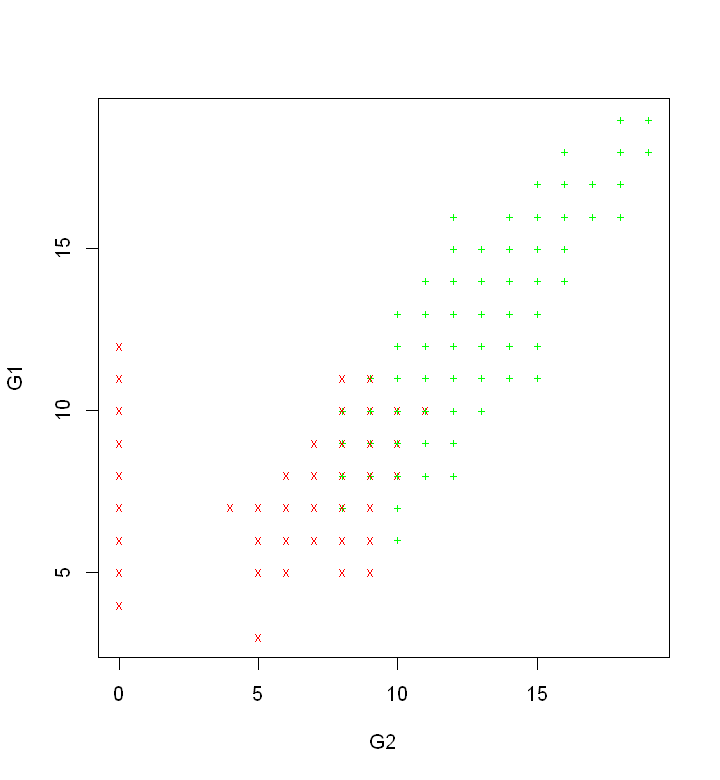

In [40]:
# Plot the partition of tree
options(repr.plot.width=6, repr.plot.height=6.5)
plot(student$G2, student$G1,
     pch=c('x', '+')[as.numeric(student$pass)],
     col=c('red', 'green')[as.numeric(student$pass)],
     cex=0.7,
     xlab='G2', ylab='G1'
    )

**Q3:** Use tree() function to construct a decision tree model to predict student performance.

In [41]:
# Build simple decision tree model from Titanic dataset
md_tree <- tree(pass ~ G1 + G2, data=student)

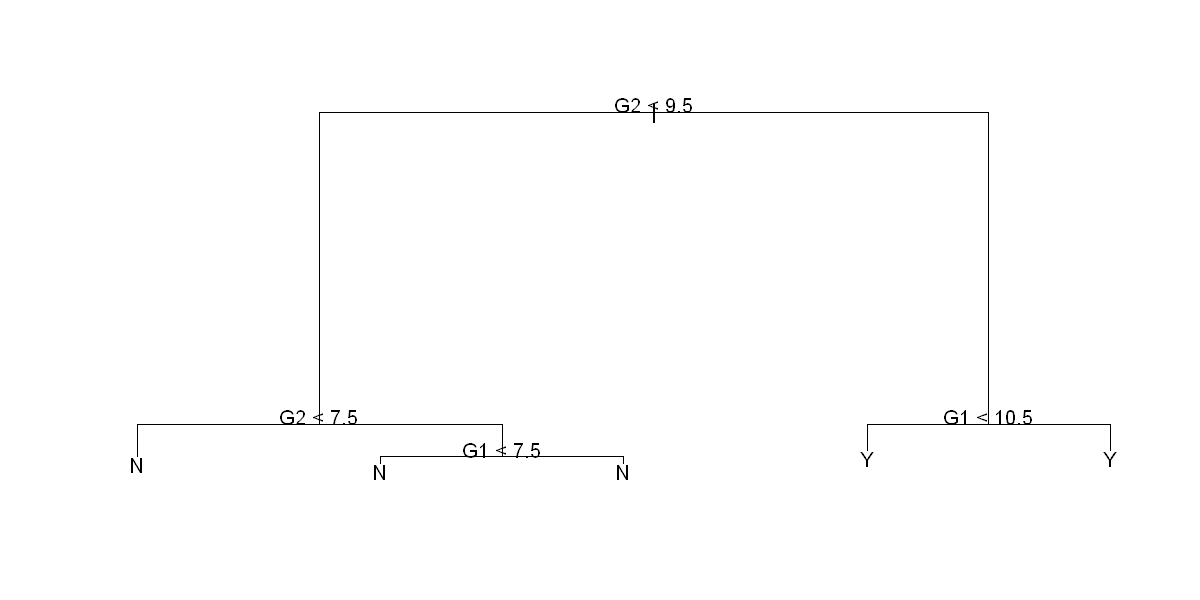

In [42]:
# Plot the tree
options(repr.plot.width=10, repr.plot.height=5)
par(cex.lab=0.8, cex.axis=0.8, cex.main=0.8, cex.sub=0.8)
plot(md_tree)  # Plot the tree
text(md_tree, pretty=1)  # Add text

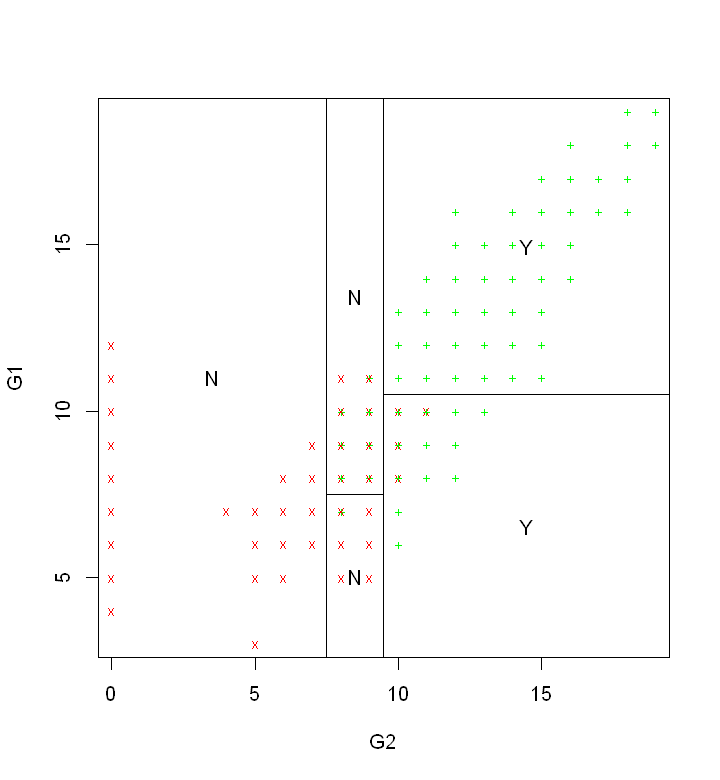

In [43]:
# Plot the partition of tree
options(repr.plot.width=6, repr.plot.height=6.5)
partition.tree(md_tree)
points(student$G2, student$G1,
       pch=c('x', '+')[as.numeric(student$pass)],
       col=c('red', 'green')[as.numeric(student$pass)],
       cex=0.7
      )

In [44]:
# Print out the tree details
print(md_tree)

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 395 500.500 Y ( 0.32911 0.67089 )  
   2) G2 < 9.5 146 130.500 N ( 0.83562 0.16438 )  
     4) G2 < 7.5 64   0.000 N ( 1.00000 0.00000 ) *
     5) G2 > 7.5 82  99.140 N ( 0.70732 0.29268 )  
      10) G1 < 7.5 16   7.481 N ( 0.93750 0.06250 ) *
      11) G1 > 7.5 66  85.340 N ( 0.65152 0.34848 ) *
   3) G2 > 9.5 249  70.750 Y ( 0.03213 0.96787 )  
     6) G1 < 10.5 54  45.300 Y ( 0.14815 0.85185 ) *
     7) G1 > 10.5 195   0.000 Y ( 0.00000 1.00000 ) *


Deviance of the node of the classification tree.

![deviance_formula](./img/deviance.png)

In [45]:
# Define the function to calculate the deviance for classification tree
node_deviance_classification_tree <- function(node_dependent_var) {
    "
    This function calculate the deviance at a node of the binary tree for classification problem.
    This metric is closely related to cross-entropy.
    Ref: http://www2.stat.duke.edu/~rcs46/lectures_2017/08-trees/08-tree-classification.pdf

    Input:
        node_dependent_var : the subset of dependent variable of current node, 2 classes [0, 1]
    "

    num_class_1 <- sum(node_dependent_var == 1)
    prob_class_1 <- num_class_1 / length(node_dependent_var)

    num_class_0 <- sum(node_dependent_var == 0)
    prob_class_0 <- num_class_0 / length(node_dependent_var)

    node_deviance <- -2 * (num_class_1 * log(prob_class_1) + num_class_0 * log(prob_class_0))
}

In [46]:
# Deviance at the root (or 1st node)
node_1 <- student
deviance_node_1 <- node_deviance_classification_tree(node_1$pass == 'Y')

# Deviance at the first left branch (or 2nd node)
node_2 <- node_1[node_1$G2 < 9.5, ]
deviance_node_2 <- node_deviance_classification_tree(node_2$pass == 'Y')

# Deviance at the first right branch (or 3rd node)
node_3 <- node_1[node_1$G2 > 9.5, ]
deviance_node_3 <- node_deviance_classification_tree(node_3$pass == 'Y')

# Compare deviance
print(paste("Root:", round(deviance_node_1, 4)))  # Max deviance, root (no split)
print(paste("1st left branch:", round(deviance_node_2, 4)))  # First split, left branch
print(paste("1st right branch:", round(deviance_node_3, 4)))  # Second split, right branch

[1] "Root: 500.504"
[1] "1st left branch: 130.4854"
[1] "1st right branch: 70.7484"


### 3. Regression Trees

**Example 2:** Baseball Players' Salary prediction.

Q1: What does the distribution of the Salary look like? How about the log(Salary)?

Q2: Divide train (first 132 obs.) and test (last 131 obs.) sets.

Q3: Build and plot a regression decision tree on train data. Plot and interpret the decision tree.

Q4: Prune the decision tree using cost-complexity pruning. Plot and interpret the pruned tree.

Q5: Compare the performance of full Regression Tree and pruned Regression Tree on test data.

Q6: Plot the tree pruning process.

In [47]:
# Inport the Baseball Players' data in 1987
# Source: https://cran.r-project.org/web/packages/ISLR/ISLR.pdf
# Consider only this subset of variables
# Salary: 1987 annual salary on opening day in thousands of dollars
# Years: Number of years in the major leagues
# RBI: Number of runs batted in in 1986
# Hits: Number of hits in 1986
# PutOuts: Number of put outs in 1986
# Walks: Number of walks in 1986
# Runs: Number of runs in 1986
ht <- ISLR::Hitters
str(ht[, c('Salary', 'Years', 'RBI', 'Hits', 'PutOuts', 'Walks', 'Runs')])

'data.frame':	322 obs. of  7 variables:
 $ Salary : num  NA 475 480 500 91.5 750 70 100 75 1100 ...
 $ Years  : int  1 14 3 11 2 11 2 3 2 13 ...
 $ RBI    : int  29 38 72 78 42 51 8 24 32 66 ...
 $ Hits   : int  66 81 130 141 87 169 37 73 81 92 ...
 $ PutOuts: int  446 632 880 200 805 282 76 121 143 0 ...
 $ Walks  : int  14 39 76 37 30 35 21 7 8 65 ...
 $ Runs   : int  30 24 66 65 39 74 23 24 26 49 ...


**Q1:** What does the distribution of the Salary look like? How about the log(Salary)?

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   67.5   190.0   425.0   535.9   750.0  2460.0      59 

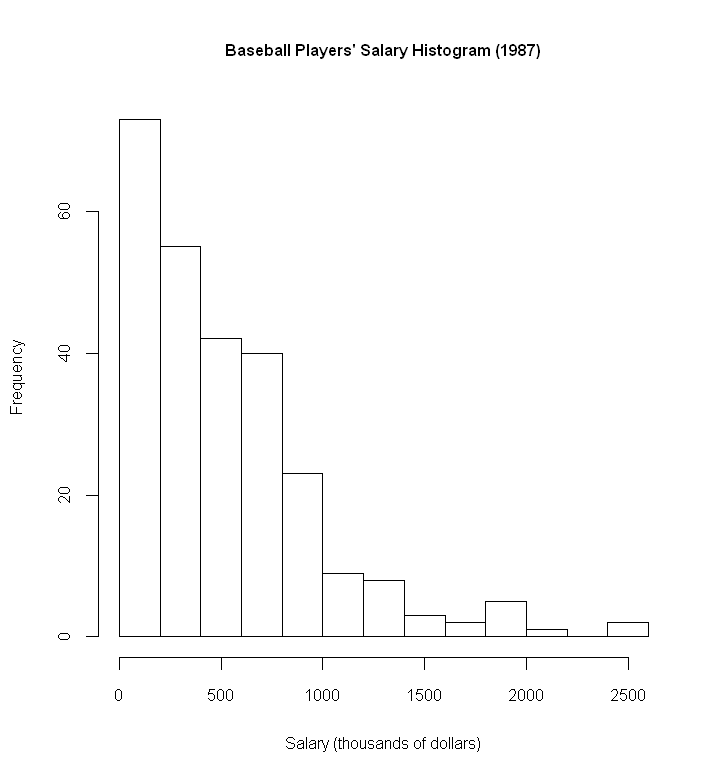

In [48]:
# Observe the annual salary value (in thousands of dollars)
summary(ht$Salary)

options(repr.plot.width=6, repr.plot.height=6.5)
par(cex.lab=0.8, cex.axis=0.8, cex.main=0.8, cex.sub=0.8)
hist(ht$Salary,
     main="Baseball Players' Salary Histogram (1987)",
     xlab='Salary (thousands of dollars)')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.212   5.247   6.052   5.927   6.620   7.808 

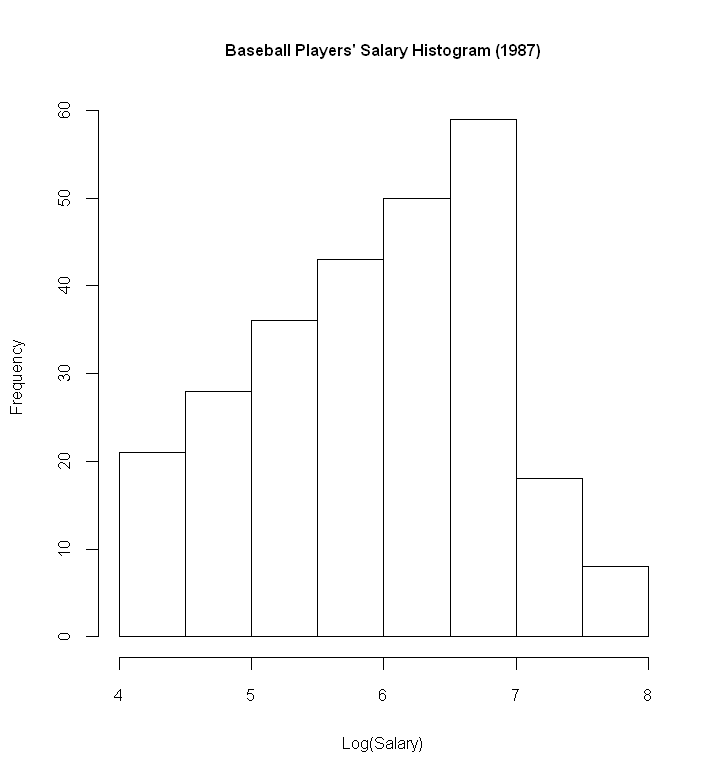

In [49]:
# Drop obs. with Salary == NA
ht <- ht[!is.na(ht$Salary), ]

# Log-transform Salary
ht$Salary <- log(ht$Salary)

# Print out to check
summary(ht$Salary)

# Plot the transformed Salary
options(repr.plot.width=6, repr.plot.height=6.5)
par(cex.lab=0.8, cex.axis=0.8, cex.main=0.8, cex.sub=0.8)
hist(ht$Salary,
     main="Baseball Players' Salary Histogram (1987)",
     xlab='Log(Salary)')

**Q2:** Divide train (first 132 obs.) and test (last 131 obs.) sets.

In [50]:
# Train-test split
set.seed(1)  # High variance
train_idx <- sample(1:nrow(ht), 132)
train_ht <- ht[train_idx, ]  # 132 obs.
test_ht <- ht[-train_idx, ]  # 131 obs.

**Q3:** Build and plot a regression decision tree on train data. Plot and interpret the decision tree.

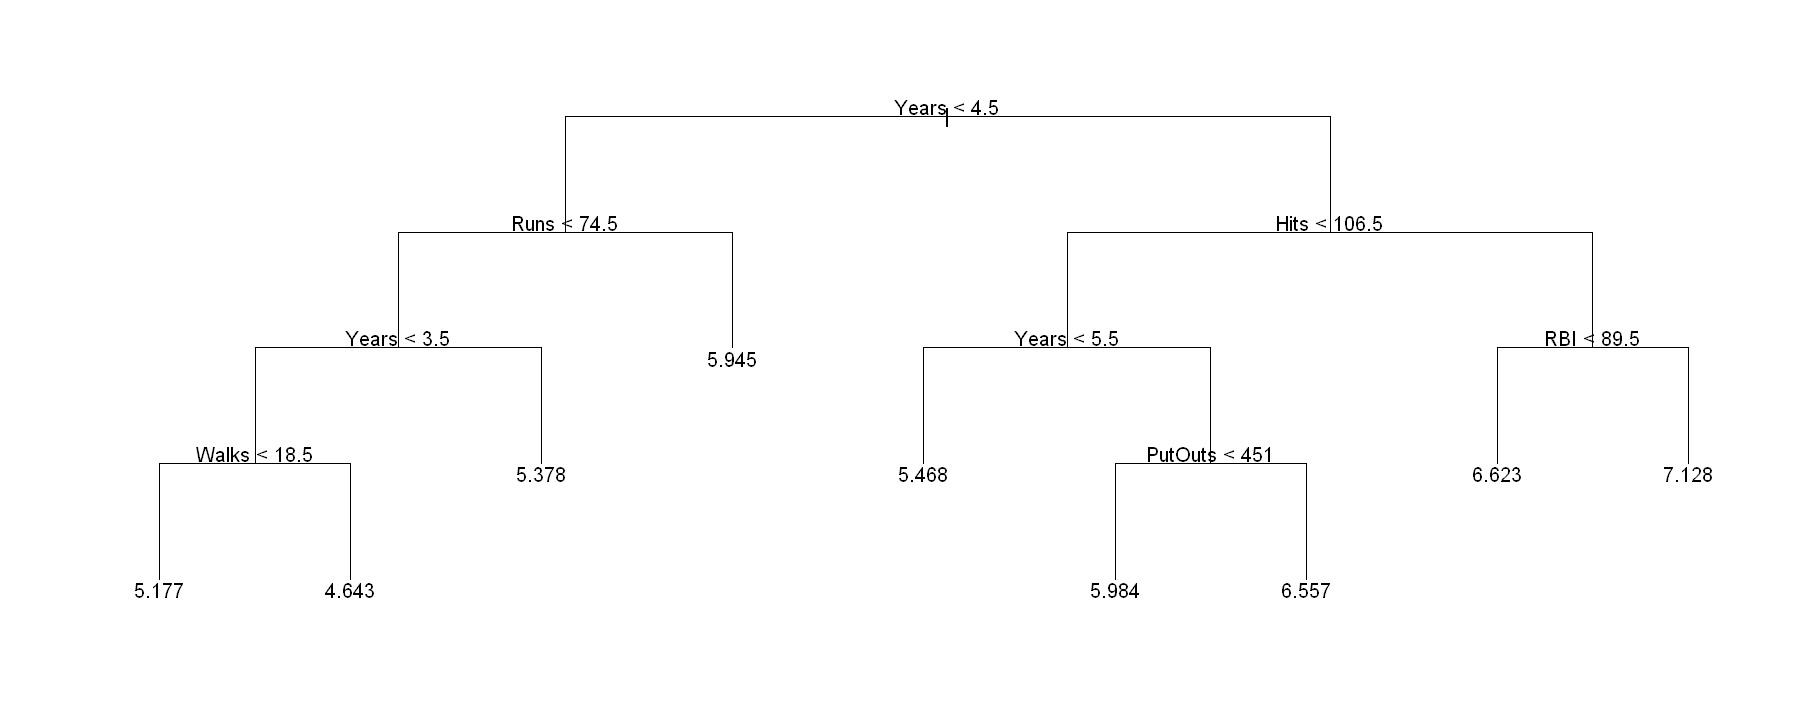

In [51]:
# Fit full regression tree (top-down greedy splitting)
md_regtree <- tree(Salary ~ Years + RBI + Hits + PutOuts + Walks + Runs, data=train_ht)

# Plot the regression tree
options(repr.plot.width=15, repr.plot.height=6)
plot(md_regtree, type='uniform')
text(md_regtree, pretty=0)

In [52]:
# Print out the tree details
md_regtree

node), split, n, deviance, yval
      * denotes terminal node

 1) root 132 103.0000 5.938  
   2) Years < 4.5 47  25.6100 5.164  
     4) Runs < 74.5 38  15.7300 4.978  
       8) Years < 3.5 25  11.0400 4.771  
        16) Walks < 18.5 6   7.9000 5.177 *
        17) Walks > 18.5 19   1.8350 4.643 *
       9) Years > 3.5 13   1.5460 5.378 *
     5) Runs > 74.5 9   3.0720 5.945 *
   3) Years > 4.5 85  33.6200 6.366  
     6) Hits < 106.5 41  11.3100 5.991  
      12) Years < 5.5 5   1.8600 5.468 *
      13) Years > 5.5 36   7.8960 6.063  
        26) PutOuts < 451 31   5.5690 5.984 *
        27) PutOuts > 451 5   0.9142 6.557 *
     7) Hits > 106.5 44  11.1800 6.715  
      14) RBI < 89.5 36   8.8750 6.623 *
      15) RBI > 89.5 8   0.6402 7.128 *

In [53]:
# RSS at the root (or 1st node)
node_1 <- train_ht
rss_node_1 <- sum((node_1$Salary - mean(node_1$Salary)) ^ 2)

# RSS at the first left branch (or 2nd node)
node_2 <- node_1[node_1$Years < 4.5, ]
rss_node_2 <- sum((node_2$Salary - mean(node_2$Salary)) ^ 2)

# RSS at the first right branch (or 3rd node)
node_3 <- node_1[node_1$Years > 4.5, ]
rss_node_3 <- sum((node_3$Salary - mean(node_3$Salary)) ^ 2)

# Compare RSS
print(paste("Root:", round(rss_node_1, 4)))  # Max RSS, root (no split)
print(paste("1st left branch:", round(rss_node_2, 4)))  # First split, left branch
print(paste("1st right branch:", round(rss_node_3, 4)))  # Second split, right branch

[1] "Root: 102.9572"
[1] "1st left branch: 25.6056"
[1] "1st right branch: 33.6235"


**Q4:** Prune the decision tree using cost-complexity pruning. Plot and interpret the pruned tree.

In [54]:
# Prune the Regression Tree
set.seed(1)
cv_regtree <- cv.tree(md_regtree)
cv_regtree

$size
[1] 9 8 7 6 5 4 3 2 1

$dev
[1]  58.56722  55.86285  54.95801  54.34745  53.50915  54.83373  60.32098
[8]  74.28324 108.79830

$k
[1]      -Inf  1.304147  1.412834  1.558635  1.666875  3.146710  6.800576
[8] 11.126931 43.728005

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

In [55]:
# Best tree size
min_idx <- which.min(cv_regtree$dev)
tree_size <- cv_regtree$size[min_idx]
tree_dev <- cv_regtree$dev[min_idx]
tree_k <- cv_regtree$k[min_idx]

print(paste0('Best tree size = ', tree_size))
print(paste0('Best RSS = ', tree_dev))
print(paste0('Best alpha = ', tree_k))

[1] "Best tree size = 5"
[1] "Best RSS = 53.5091541192236"
[1] "Best alpha = 1.66687474259829"


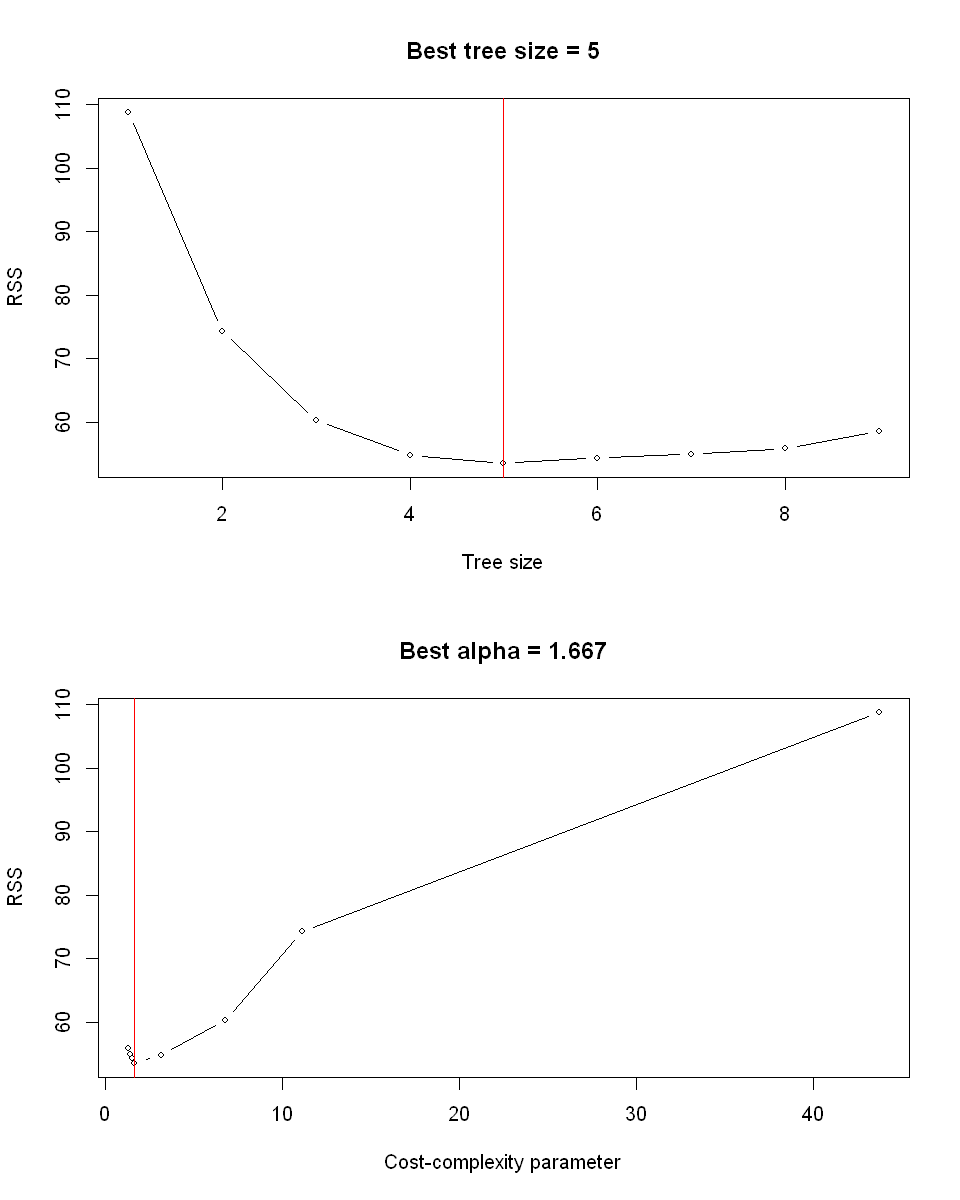

In [56]:
# Show the Decision Tree
options(repr.plot.width=8, repr.plot.height=10)
par(mfrow=c(2, 1))

# Tree size, number of nodes
plot(cv_regtree$size, cv_regtree$dev, type='b', cex=0.7,
     xlab='Tree size', ylab='RSS', main=paste0('Best tree size = ', tree_size)
    )
abline(v=tree_size, col='red')  # Best tree size

# Cost-complexity param, alpha
plot(cv_regtree$k, cv_regtree$dev, type='b', cex=0.7,
     xlab='Cost-complexity parameter', ylab='RSS',
     main=paste0('Best alpha = ', round(tree_k, 3))
    )
abline(v=tree_k, col='red')  # Best tree size

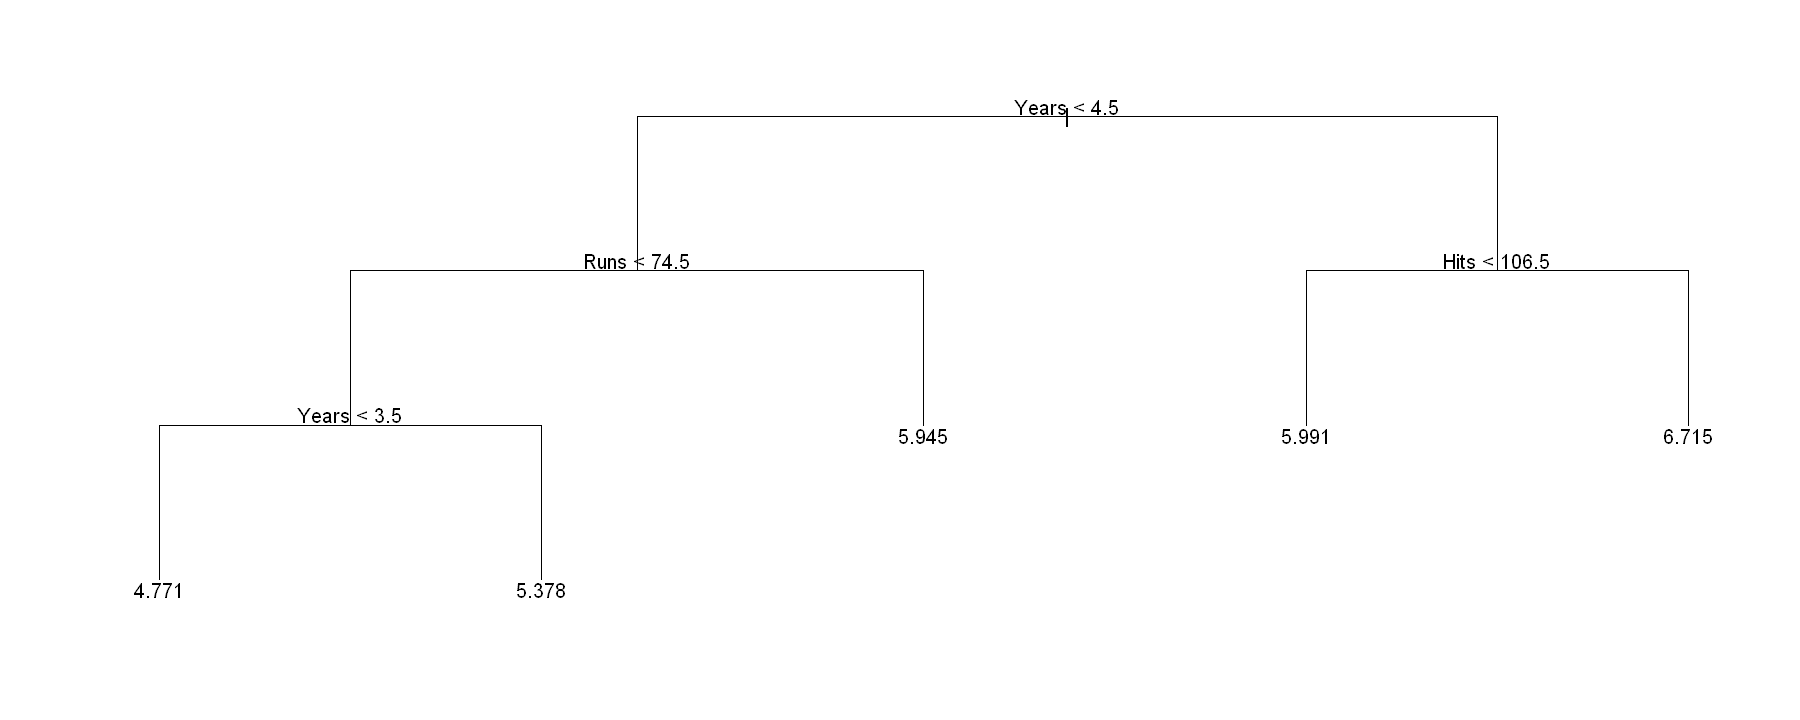

In [57]:
# Prune the tree
prune_regtree <- prune.tree(md_regtree, best=5)

# Show the tree
options(repr.plot.width=15, repr.plot.height=6)
plot(prune_regtree, type='uniform')
text(prune_regtree, pretty=0)

**Q5:** Compare the performance of full Regression Tree and pruned Regression Tree on test data.

In [58]:
# RSS full Regression Tree
pred_full_regtree <- predict(md_regtree, newdata=test_ht)
mse_full_regtree <- mean((pred_full_regtree - mean(test_ht$Salary)) ^ 2)
mse_full_regtree

# RSS pruned Regression Tree
pred_pruned_regtree <- predict(prune_regtree, newdata=test_ht)
mse_pruned_regtree <- mean((pred_pruned_regtree - mean(test_ht$Salary)) ^ 2)
mse_pruned_regtree

[1] 0.5227048

[1] 0.4986118

**Q6:** Plot the tree pruning process.

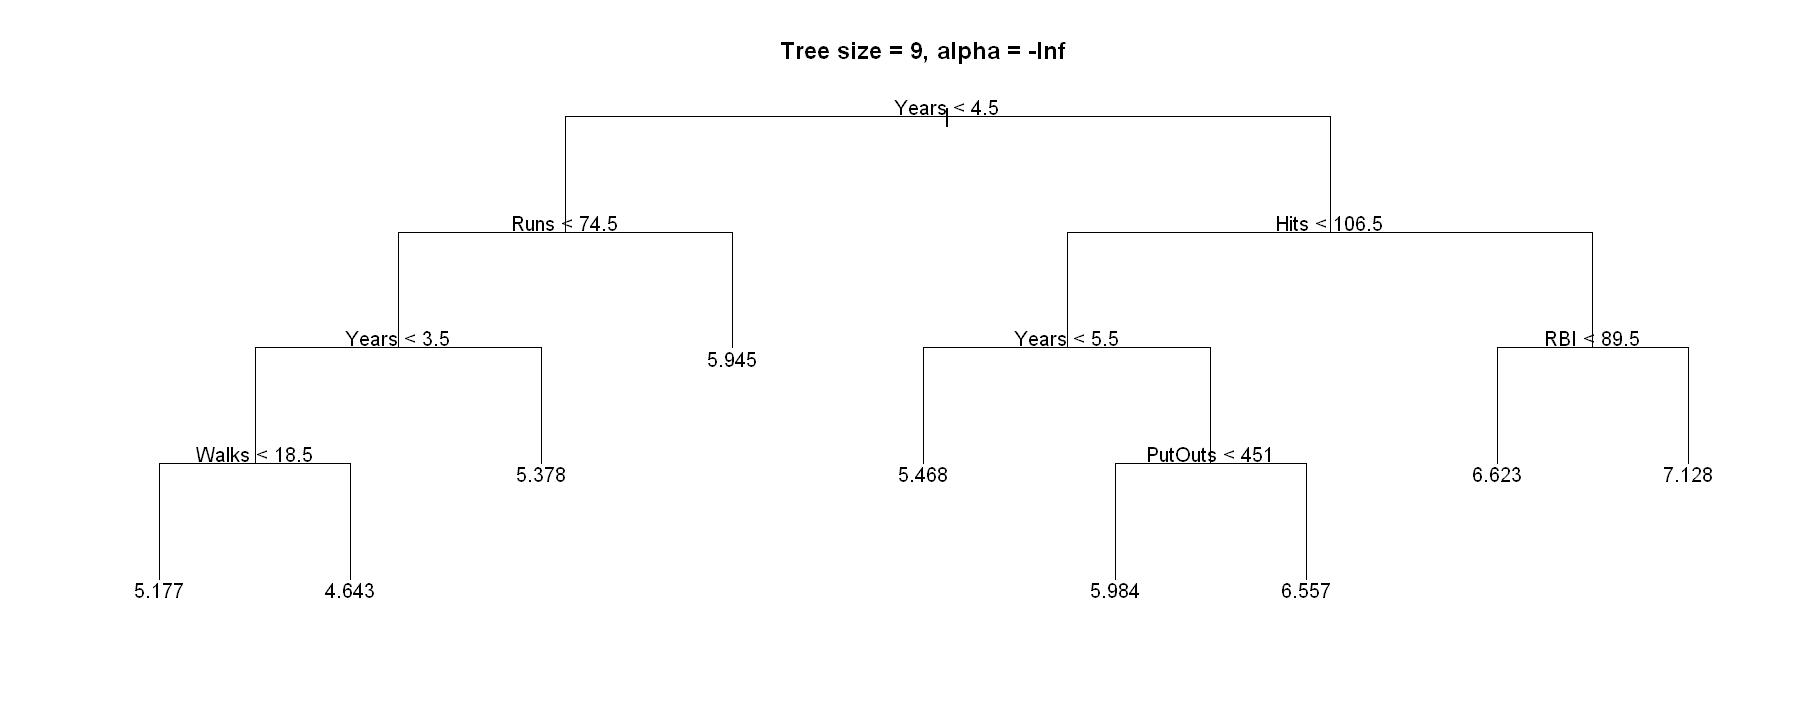

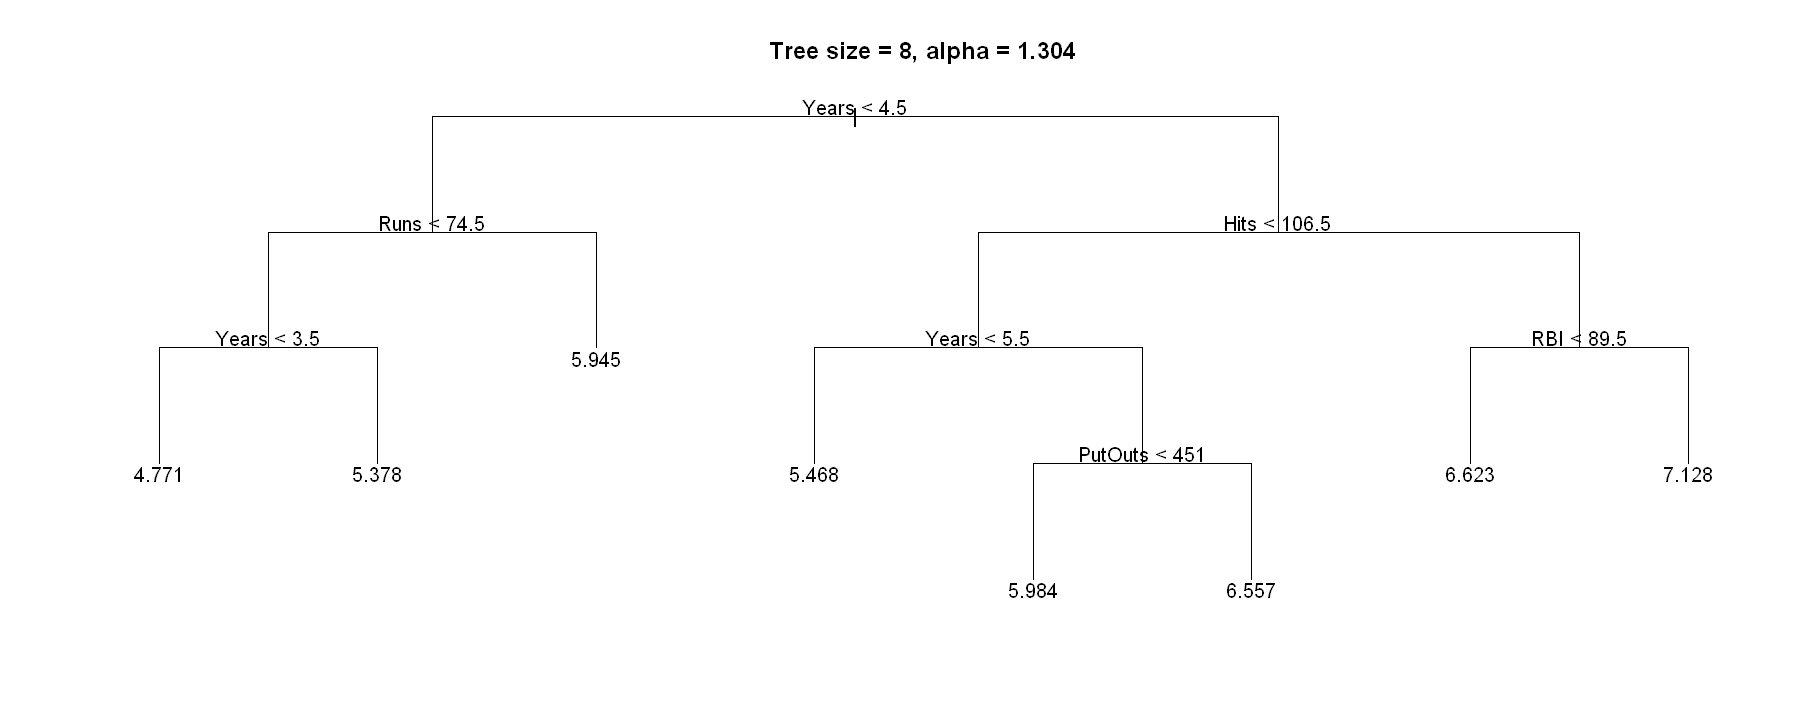

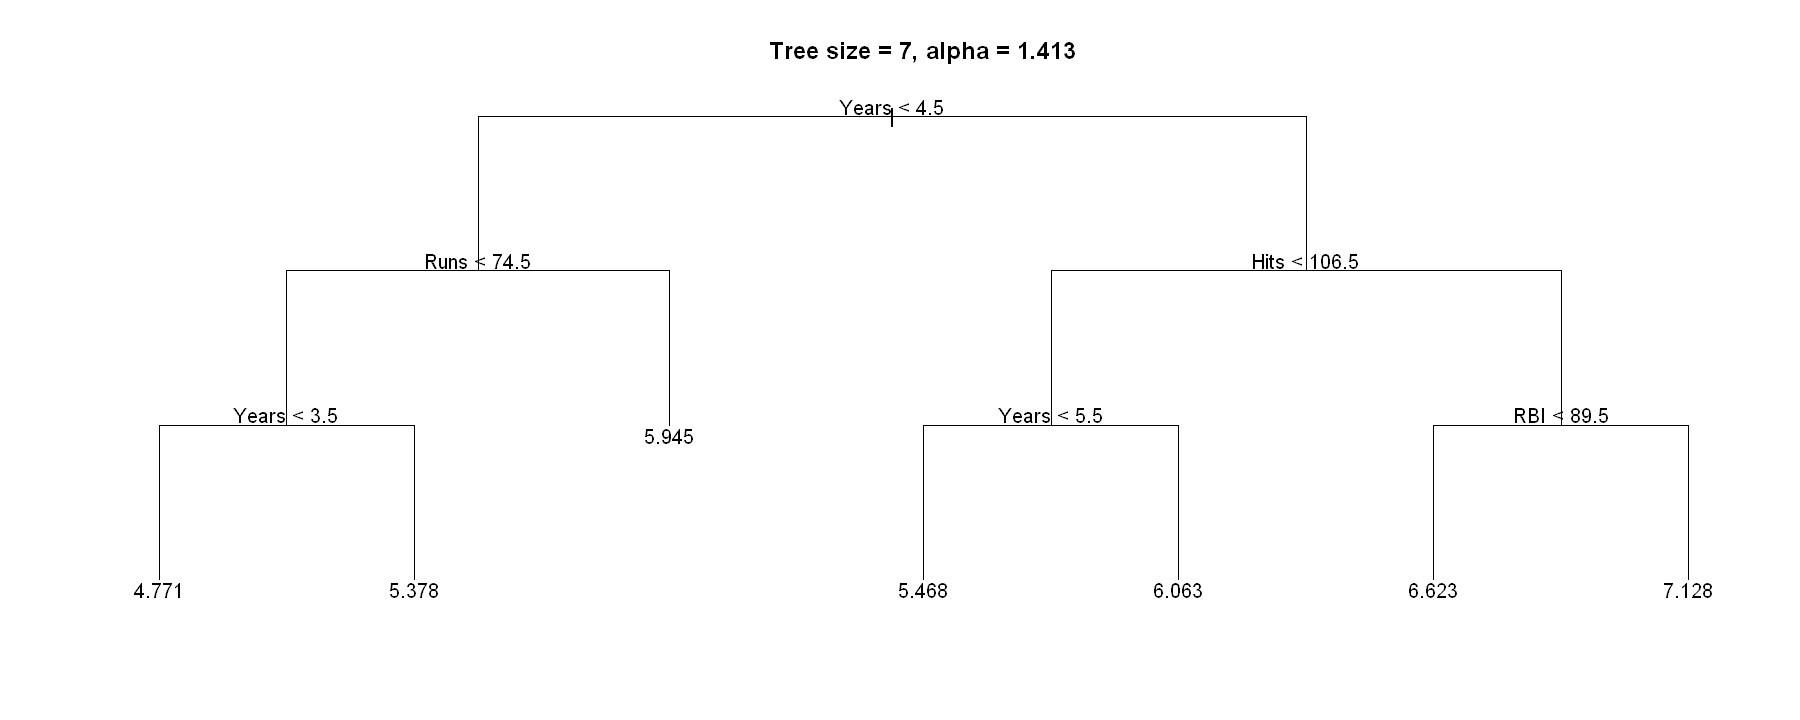

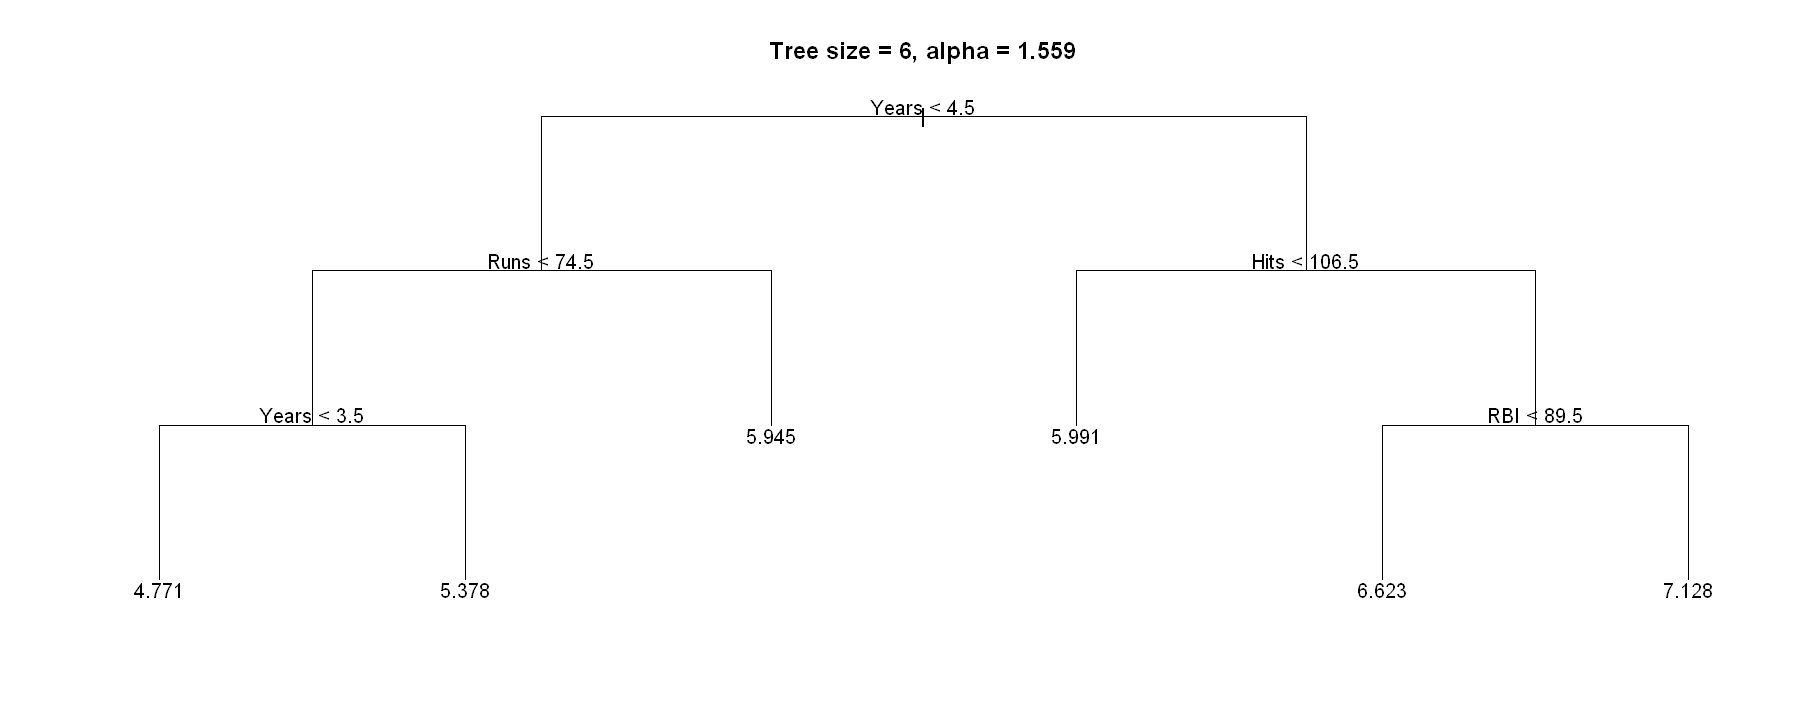

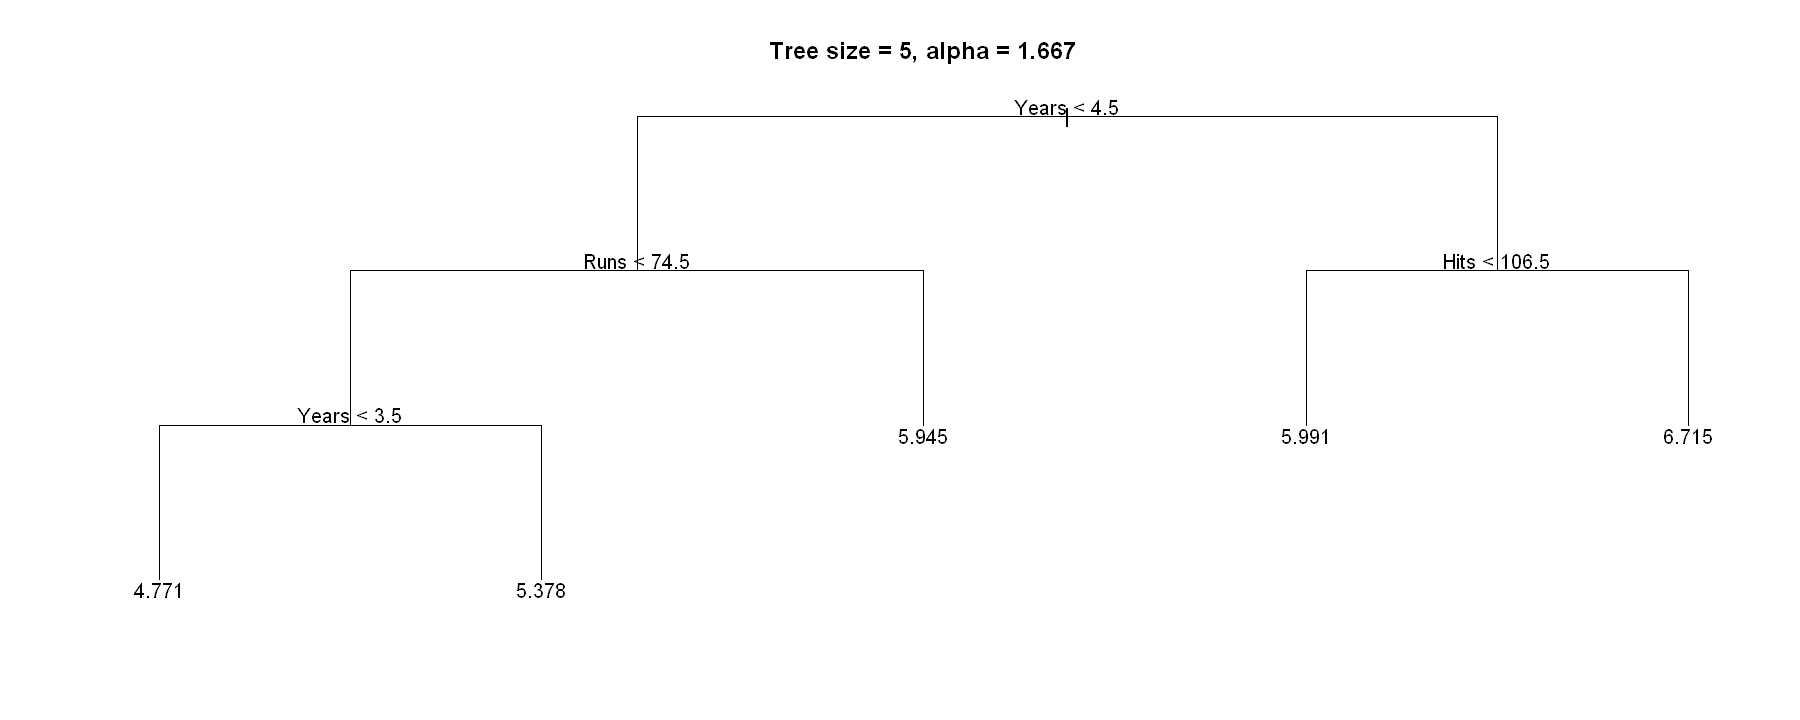

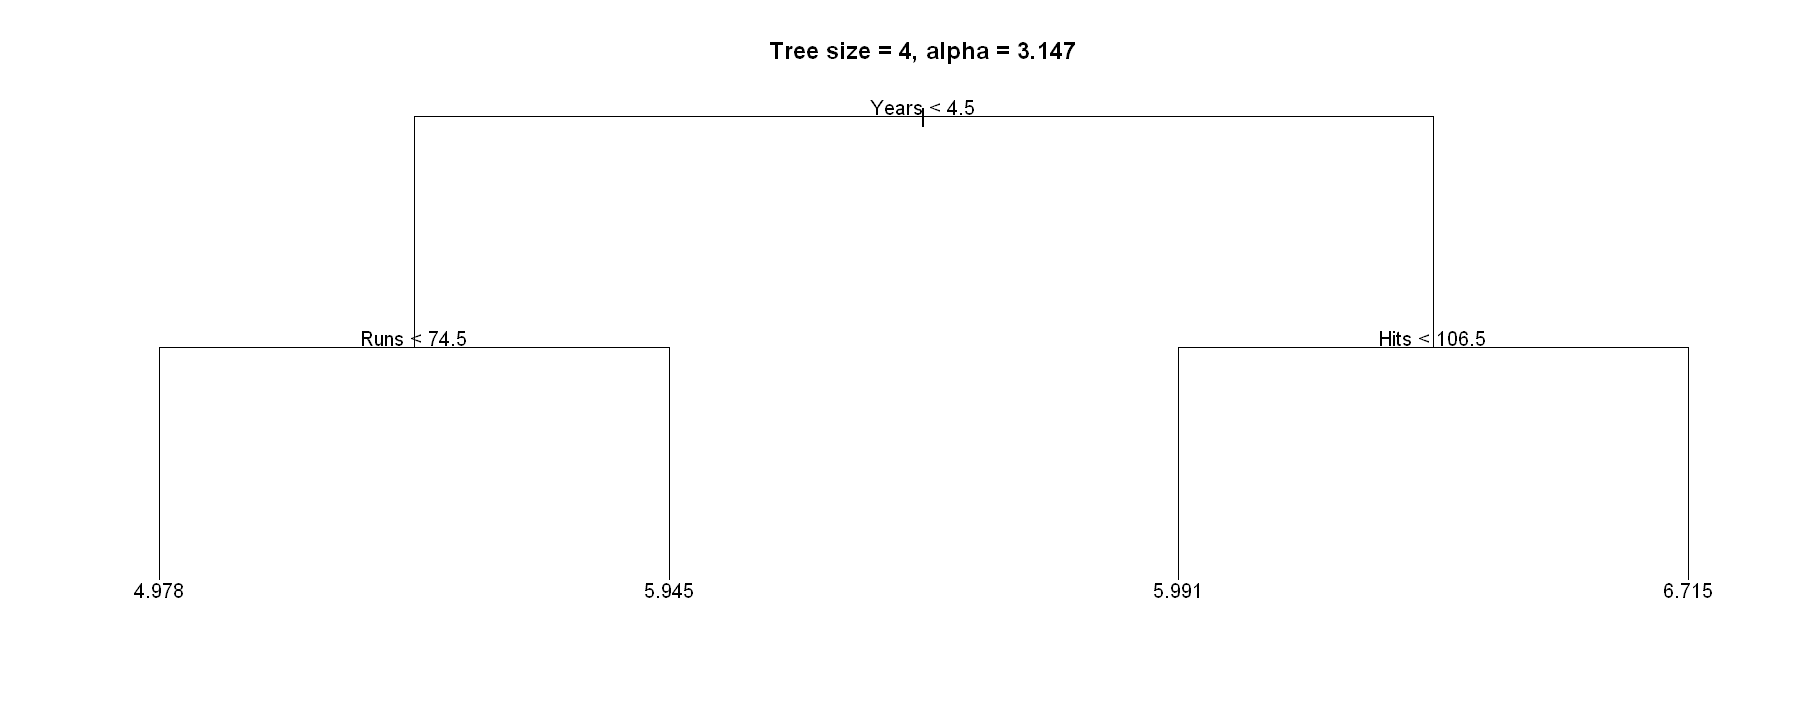

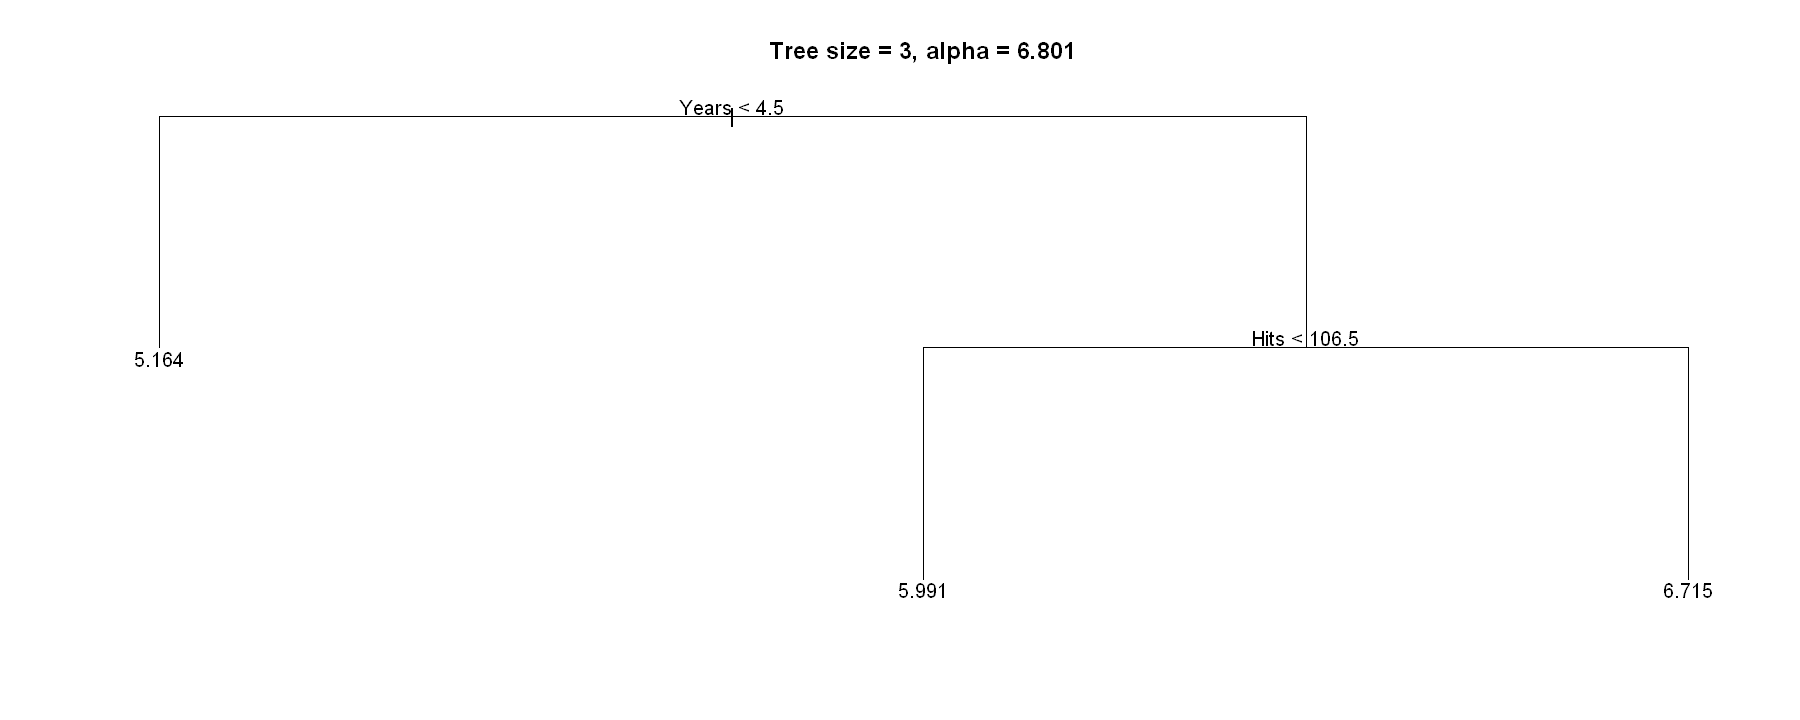

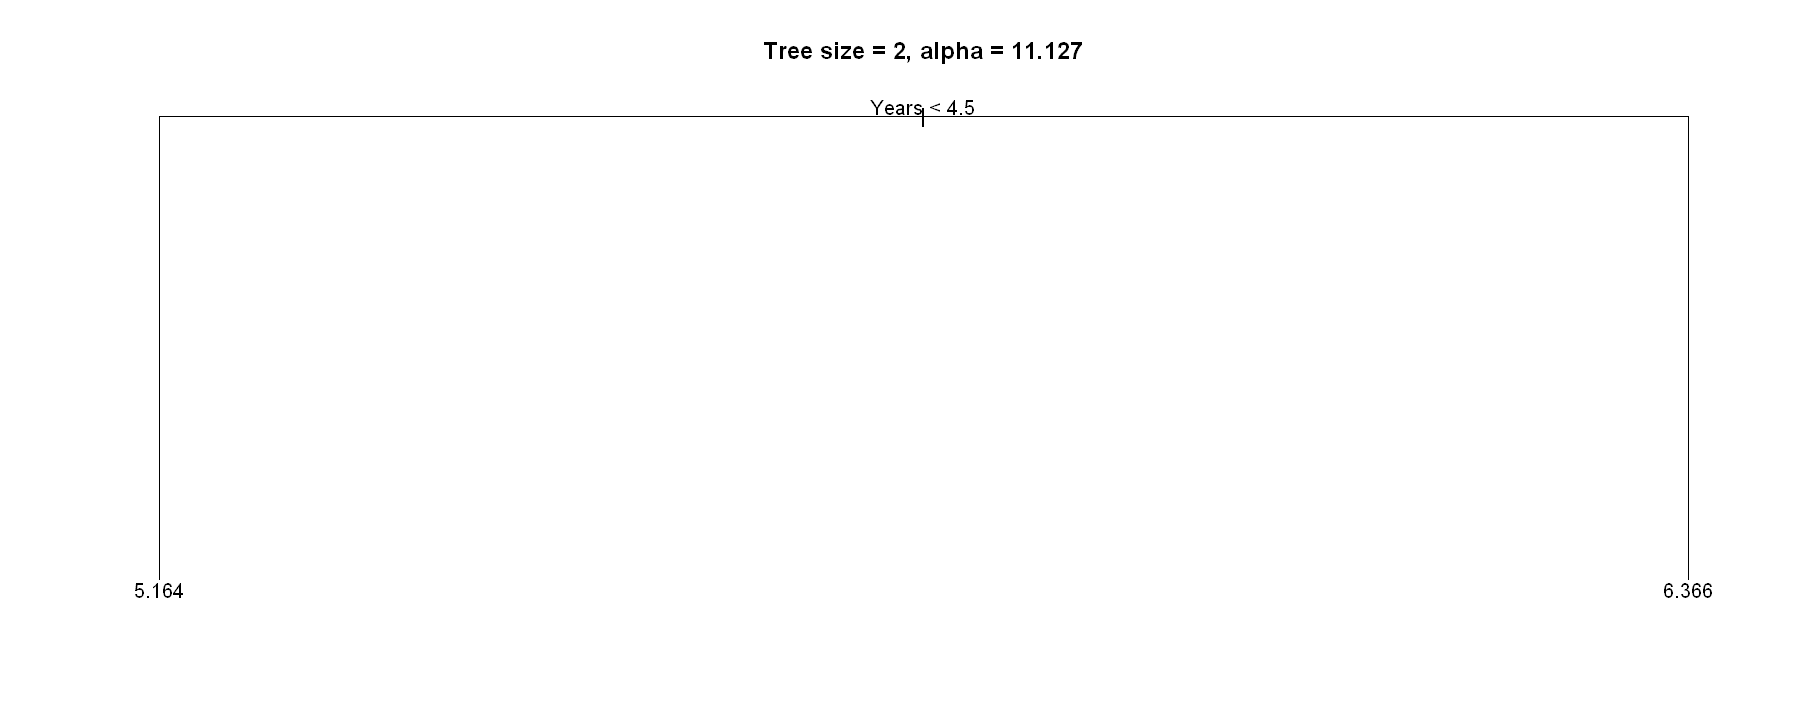

In [59]:
for (i in 1:(length(cv_regtree$size)-1)) {
    
    # Prune the tree
    tree_size = cv_regtree$size[i]
    alpha = cv_regtree$k[i]
    prune_regtree_temp <- prune.tree(md_regtree, best=tree_size)

    # Show the tree
    plot(prune_regtree_temp, type='uniform')
    text(prune_regtree_temp, pretty=0)
    title(main=paste0('Tree size = ', tree_size, ', alpha = ', round(alpha, 3)))
    }

### 4. Classification Tree

#### 4.1. The Iris dataset
![ieseg logo](./img/iris-machinelearning.png)

Source: https://www.datacamp.com/community/tutorials/machine-learning-in-r

**Example 4:** The Iris dataset

Q1: What is the distribution of the response Species?

Q2: Build a classification decision tree on the Iris data. Plot and interpret the tree.

Q3: Calculate the Classification error rate, Cross-entropy, Gini index and Deviance before and after spliting at the tree branch 12.

In [60]:
# The Iris dataset
# Sepal.Length : sepal length in cm
# Sepal.Width  : sepal width in cm
# Petal.Length : petal length in cm
# Petal.Width  : petal length in cm
# Species      : type of iris plant, i.e. Setosa, Versicolour, Virginica
ir <- datasets::iris
str(ir)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


**Q1:** What is the distribution of the response Species?

In [61]:
# Check the response
table(ir$Species) / nrow(ir)


    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

**Q2:** Build a classification decision tree on the Iris data. Plot and interpret the tree.

In [62]:
# Fit the classification tree
md_classtree <- tree(Species ~ ., data=ir)
summary(md_classtree)


Classification tree:
tree(formula = Species ~ ., data = ir)
Variables actually used in tree construction:
[1] "Petal.Length" "Petal.Width"  "Sepal.Length"
Number of terminal nodes:  6 
Residual mean deviance:  0.1253 = 18.05 / 144 
Misclassification error rate: 0.02667 = 4 / 150 

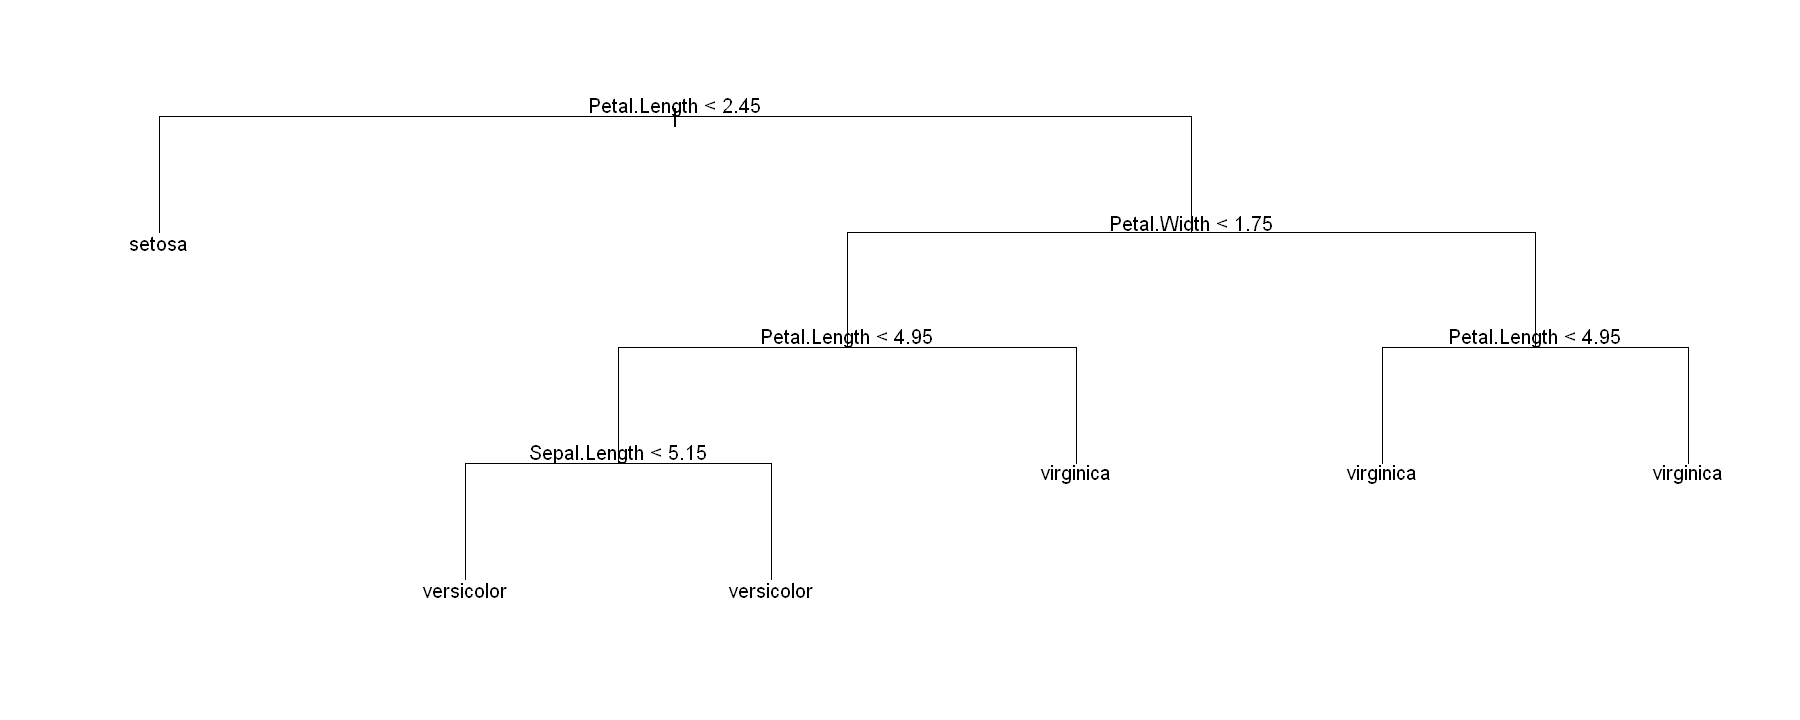

In [63]:
# Plot the classification tree
options(repr.plot.width=15, repr.plot.height=6)
plot(md_classtree, type='uniform')
text(md_classtree, pretty=0)

In [64]:
# Print out the tree details
md_classtree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 150 329.600 setosa ( 0.33333 0.33333 0.33333 )  
   2) Petal.Length < 2.45 50   0.000 setosa ( 1.00000 0.00000 0.00000 ) *
   3) Petal.Length > 2.45 100 138.600 versicolor ( 0.00000 0.50000 0.50000 )  
     6) Petal.Width < 1.75 54  33.320 versicolor ( 0.00000 0.90741 0.09259 )  
      12) Petal.Length < 4.95 48   9.721 versicolor ( 0.00000 0.97917 0.02083 )  
        24) Sepal.Length < 5.15 5   5.004 versicolor ( 0.00000 0.80000 0.20000 ) *
        25) Sepal.Length > 5.15 43   0.000 versicolor ( 0.00000 1.00000 0.00000 ) *
      13) Petal.Length > 4.95 6   7.638 virginica ( 0.00000 0.33333 0.66667 ) *
     7) Petal.Width > 1.75 46   9.635 virginica ( 0.00000 0.02174 0.97826 )  
      14) Petal.Length < 4.95 6   5.407 virginica ( 0.00000 0.16667 0.83333 ) *
      15) Petal.Length > 4.95 40   0.000 virginica ( 0.00000 0.00000 1.00000 ) *

**Q3:** Calculate the Deviance, Classification error rate, Cross-entropy abd Gini-index before and after spliting at the tree branch 12.

In [65]:
# Get data for node 12
node_12 <- ir[(ir$Petal.Length > 2.45) & (ir$Petal.Width < 1.75) & (ir$Petal.Length < 4.95), ]
print(nrow(node_12))
print(table(node_12$Species))

[1] 48

    setosa versicolor  virginica 
         0         47          1 


In [66]:
# Get data for node 24
node_24 <- node_12[node_12$Sepal.Length < 5.15, ]
print(nrow(node_24))
print(table(node_24$Species))

[1] 5

    setosa versicolor  virginica 
         0          4          1 


In [67]:
# Get data for node 25
node_25 <- node_12[node_12$Sepal.Length > 5.15, ]
print(nrow(node_25))
print(table(node_25$Species))

[1] 43

    setosa versicolor  virginica 
         0         43          0 


Compare deviance before and after splitting at tree brand 12.

![deviance_formula](./img/deviance.png)

In [68]:
# Deviance of the classification tree
# Ref: http://www2.stat.duke.edu/~rcs46/lectures_2017/08-trees/08-tree-classification.pdf
deviance_tree <- -2 * (50 * log(0.33333) + 50 * log(0.33333) + 50 * log(0.33333))
print(deviance_tree)

[1] 329.5867


In [69]:
# Deviance before splitting
# dev12 <- -2 * (0 * log(0.00000) + 47 * log(0.97917) + 1 * log(0.02083))
dev12 <- -2 * (47 * log(0.97917) + 1 * log(0.02083))

# Deviance before splitting
dev24 <- -2 * (4 * log(0.80000) + 1 * log(0.20000))
dev25 <- -2 * (43 * log(1.00000))
combined_dev <- dev24 * 5/48 + dev25 * 43/48

print(paste0('Deviance at node 12: ', dev12))
print(paste0('Combined deviance of node 24 and 25: ', combined_dev))

[1] "Deviance at node 12: 9.72142251255943"
[1] "Combined deviance of node 24 and 25: 0.521252524518946"


Compare classification error rate before and after splitting at tree brand 12.

![classification_error_rate](./img/classification_error_rate.png)

In [70]:
# Error rate before splitting
e12 <- 1 - 0.97917  # Node 12

# Error rate after splitting
e24 <- 1 - 0.80000  # Node 24
e25 <- 1 - 1.00000  # Node 25
combined_e <- e24 * 5/48 + e25 * 43/48

print(paste0('Error rate at node 12: ', e12))
print(paste0('Combined error rate of node 24 and 25: ', combined_e))

[1] "Error rate at node 12: 0.02083"
[1] "Combined error rate of node 24 and 25: 0.0208333333333333"


Compare cross-entropy before and after splitting at tree brand 12.

![cross-entropy](./img/cross-entropy.png)

In [71]:
# Cross-entropy before splitting
ce12 <- - 0.97917 * log(0.97917) - 0.02083 * log(0.02083)  # Node 12

# Cross-entropy after splitting
ce24 <- - 0.80000 * log(0.80000) - 0.20000 * log(0.20000)  # Node 24
ce25 <- - 1.00000 * log(1.00000)  # Node 25
combined_ce <- ce24 * 5/48 + ce25 * 43/48

print(paste0('Cross-entropy at node 12: ', ce12))
print(paste0('Combined cross-entropy of node 24 and 25: ', combined_ce))

[1] "Cross-entropy at node 12: 0.101251983469098"
[1] "Combined cross-entropy of node 24 and 25: 0.0521252524518946"


Compare gini-index before and after splitting at tree brand 12.

![gini-index](./img/gini-index.png)

In [72]:
# Gini-index before splitting
gini12 <- 0.00000 * (1 - 0.00000) + 0.97917 * (1 - 0.97917) + 0.02083 * (1 - 0.02083)  # Node 12

# Gini-index after splitting
gini24 <- 0.00000 * (1 - 0.00000) + 0.80000 * (1 - 0.80000) + 0.20000 * (1 - 0.20000)  # Node 24
gini25 <- 0.00000 * (1 - 0.00000) + 1.00000 * (1 - 1.00000) + 0.00000 * (1 - 0.00000)  # Node 25
combined_gini <- gini24 * 5/48 + gini25 * 43/48

print(paste0('Gini-index at node 12: ', ce12))
print(paste0('Combined gini-index of node 24 and 25: ', combined_ce))

[1] "Gini-index at node 12: 0.101251983469098"
[1] "Combined gini-index of node 24 and 25: 0.0521252524518946"


#### 4.2. Node impurity function for classification tree

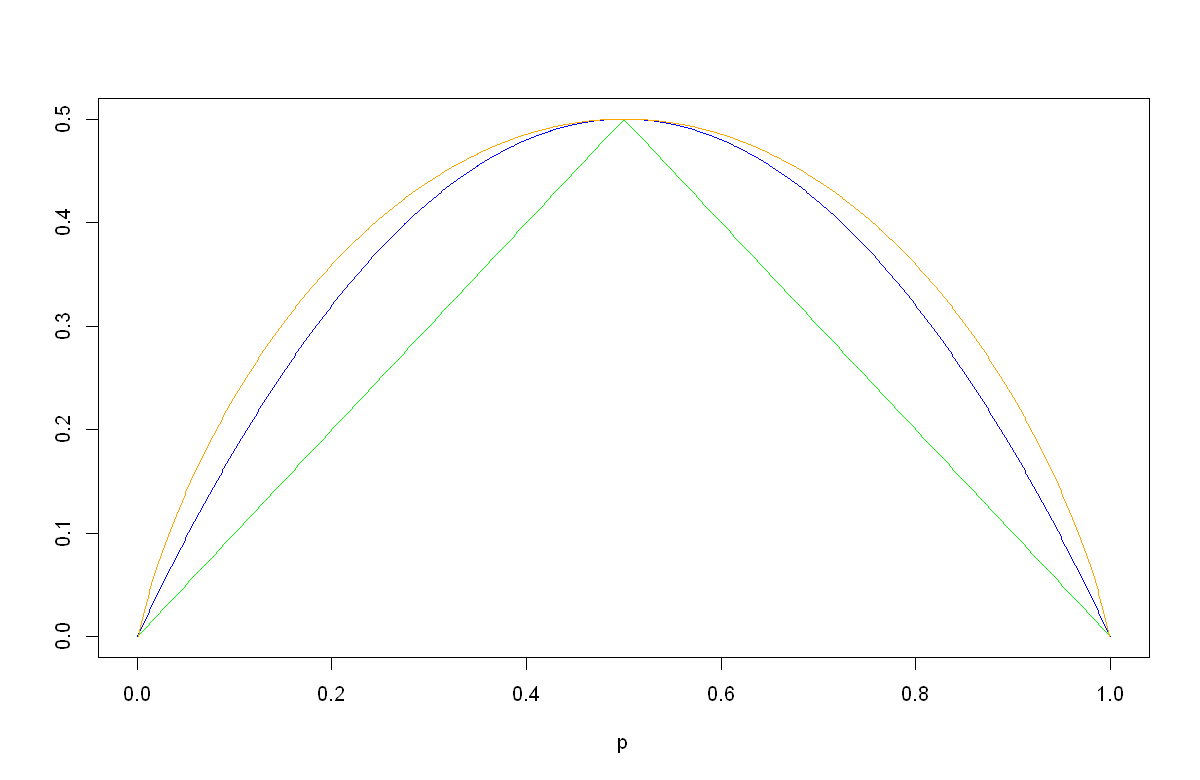

In [73]:
# Node impurity function for 2-class classification
error <- function(pmk) { pmin(1 - pmk, pmk) }  # Misclassification error
gini <- function(pmk) { pmk * (1 - pmk) + (1 - pmk) * pmk }  # Gini index
deviance <- function(pmk) { -pmk * log(pmk) - (1 - pmk) * log(1 - pmk) }  # Cross-entropy or deviance

# Create p value in [0; 1]
p <- seq(0, 1, 0.001)

# Scale deviance to range [0; 0.5]
custom_scale <- function(v, a, b) { (b - a) * (v - min(v, na.rm=T)) / (max(v, na.rm=T) - min(v, na.rm=T)) + a }

# Plot 3 inpurity function for 2-class classification
options(repr.plot.width=10, repr.plot.height=6.5)
plot(p, error(p), col='green', type='l', ylab='')
lines(p, gini(p), col='blue', type='l')
lines(p, custom_scale(deviance(p), 0, 0.5), col='orange', type='l')

## Lab: Decision Tree, Bagging and Boosting

1. Cars Sales Data - Classification Tree
2. Cars Sales Data - Regression Tree
3. Boston Housing Data - Bagging and Random Forests
4. Boston Housing Data - Boosting Regression Tree
5. Student's Performance - Benchmarking - Classification

### Lab 1: Cars Sales Data - Classification Tree

- Q1: Build and evaluate the Decision Tree model with train (first 200 obs) / test (last 200 obs) set.  
- Q2: Prune the Decision Tree model at Q1. Does it perform better?

#### Import, explore and prepare data

In [74]:
# Load require packages
library(tree)  # Regression and classification tree
library(ISLR)  # Dataset

In [75]:
# Load and explore the dataset
# Sales: Unit sales (in thousands) at each location
# CompPrice: Price charged by competitor at each location
# Income: Community income level (in thousands of dollars)
# Advertising: Local advertising budget for company at each location (in thousands of dollars)
# Population: Population size in region (in thousands)
# Price: Price company charges for car seats at each site
# ShelveLoc: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
# Age: Average age of the local population
# Education: Education level at each location
# Urban: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
# US: A factor with levels No and Yes to indicate whether the store is in the US or not
cs <- ISLR::Carseats
str(cs)

'data.frame':	400 obs. of  11 variables:
 $ Sales      : num  9.5 11.22 10.06 7.4 4.15 ...
 $ CompPrice  : num  138 111 113 117 141 124 115 136 132 132 ...
 $ Income     : num  73 48 35 100 64 113 105 81 110 113 ...
 $ Advertising: num  11 16 10 4 3 13 0 15 0 0 ...
 $ Population : num  276 260 269 466 340 501 45 425 108 131 ...
 $ Price      : num  120 83 80 97 128 72 108 120 124 124 ...
 $ ShelveLoc  : Factor w/ 3 levels "Bad","Good","Medium": 1 2 3 3 1 1 3 2 3 3 ...
 $ Age        : num  42 65 59 55 38 78 71 67 76 76 ...
 $ Education  : num  17 10 12 14 13 16 15 10 10 17 ...
 $ Urban      : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 1 2 2 1 1 ...
 $ US         : Factor w/ 2 levels "No","Yes": 2 2 2 2 1 2 1 2 1 2 ...


In [76]:
# Check NAs
apply(is.na(cs), 2, sum)

Sales   CompPrice      Income Advertising  Population       Price 
          0           0           0           0           0           0 
  ShelveLoc         Age   Education       Urban          US 
          0           0           0           0           0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   5.390   7.490   7.496   9.320  16.270 

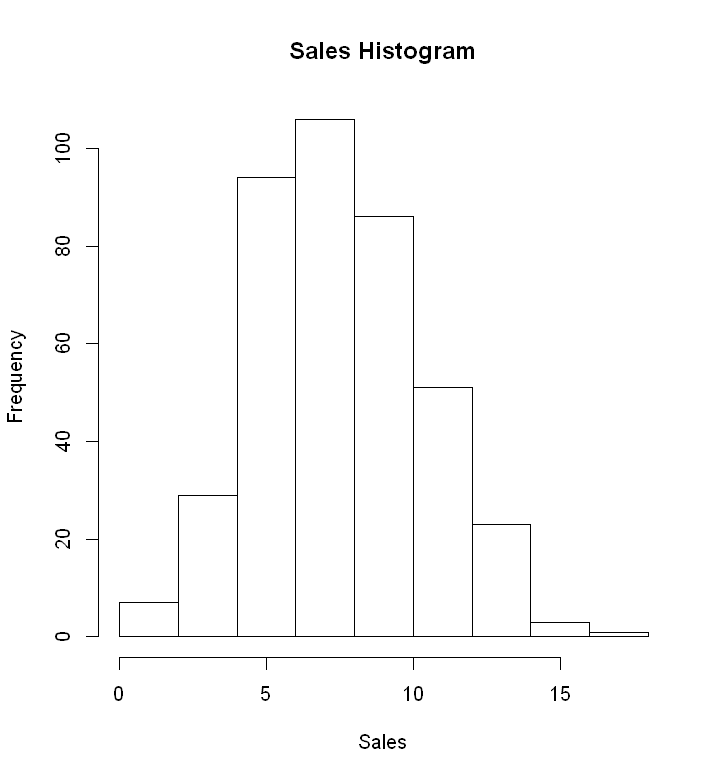

In [77]:
# Check the target variable
summary(cs$Sales)

options(repr.plot.width=6, repr.plot.height=6.5)
hist(cs$Sales,
     main='Sales Histogram', xlab='Sales')

In [78]:
# Create a new target variable for classification problem
cs$High <- as.factor(ifelse(cs$Sales <= 8, 'No', 'Yes'))
cs$Sales <- NULL  # Drop Sales


  No  Yes 
0.59 0.41 

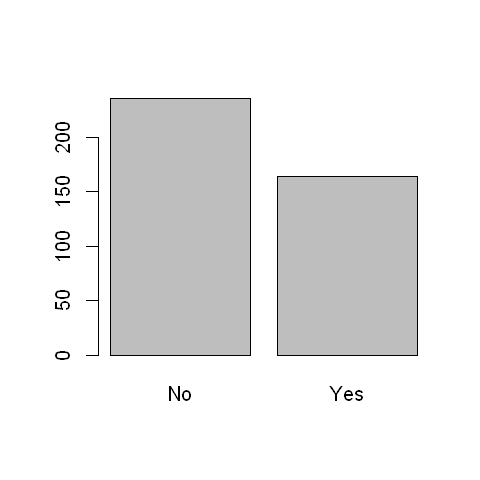

In [79]:
# Check the new target variable
table(cs$High) / nrow(cs)  # Almost balnaced

options(repr.plot.width=4, repr.plot.height=4)
barplot(table(cs$High))

#### Quick test the Decision Tree model using the whole data

In [80]:
# Fit the Decision Tree model
md_tree <- tree(High ~ ., data=cs)
summary(md_tree)


Classification tree:
tree(formula = High ~ ., data = cs)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

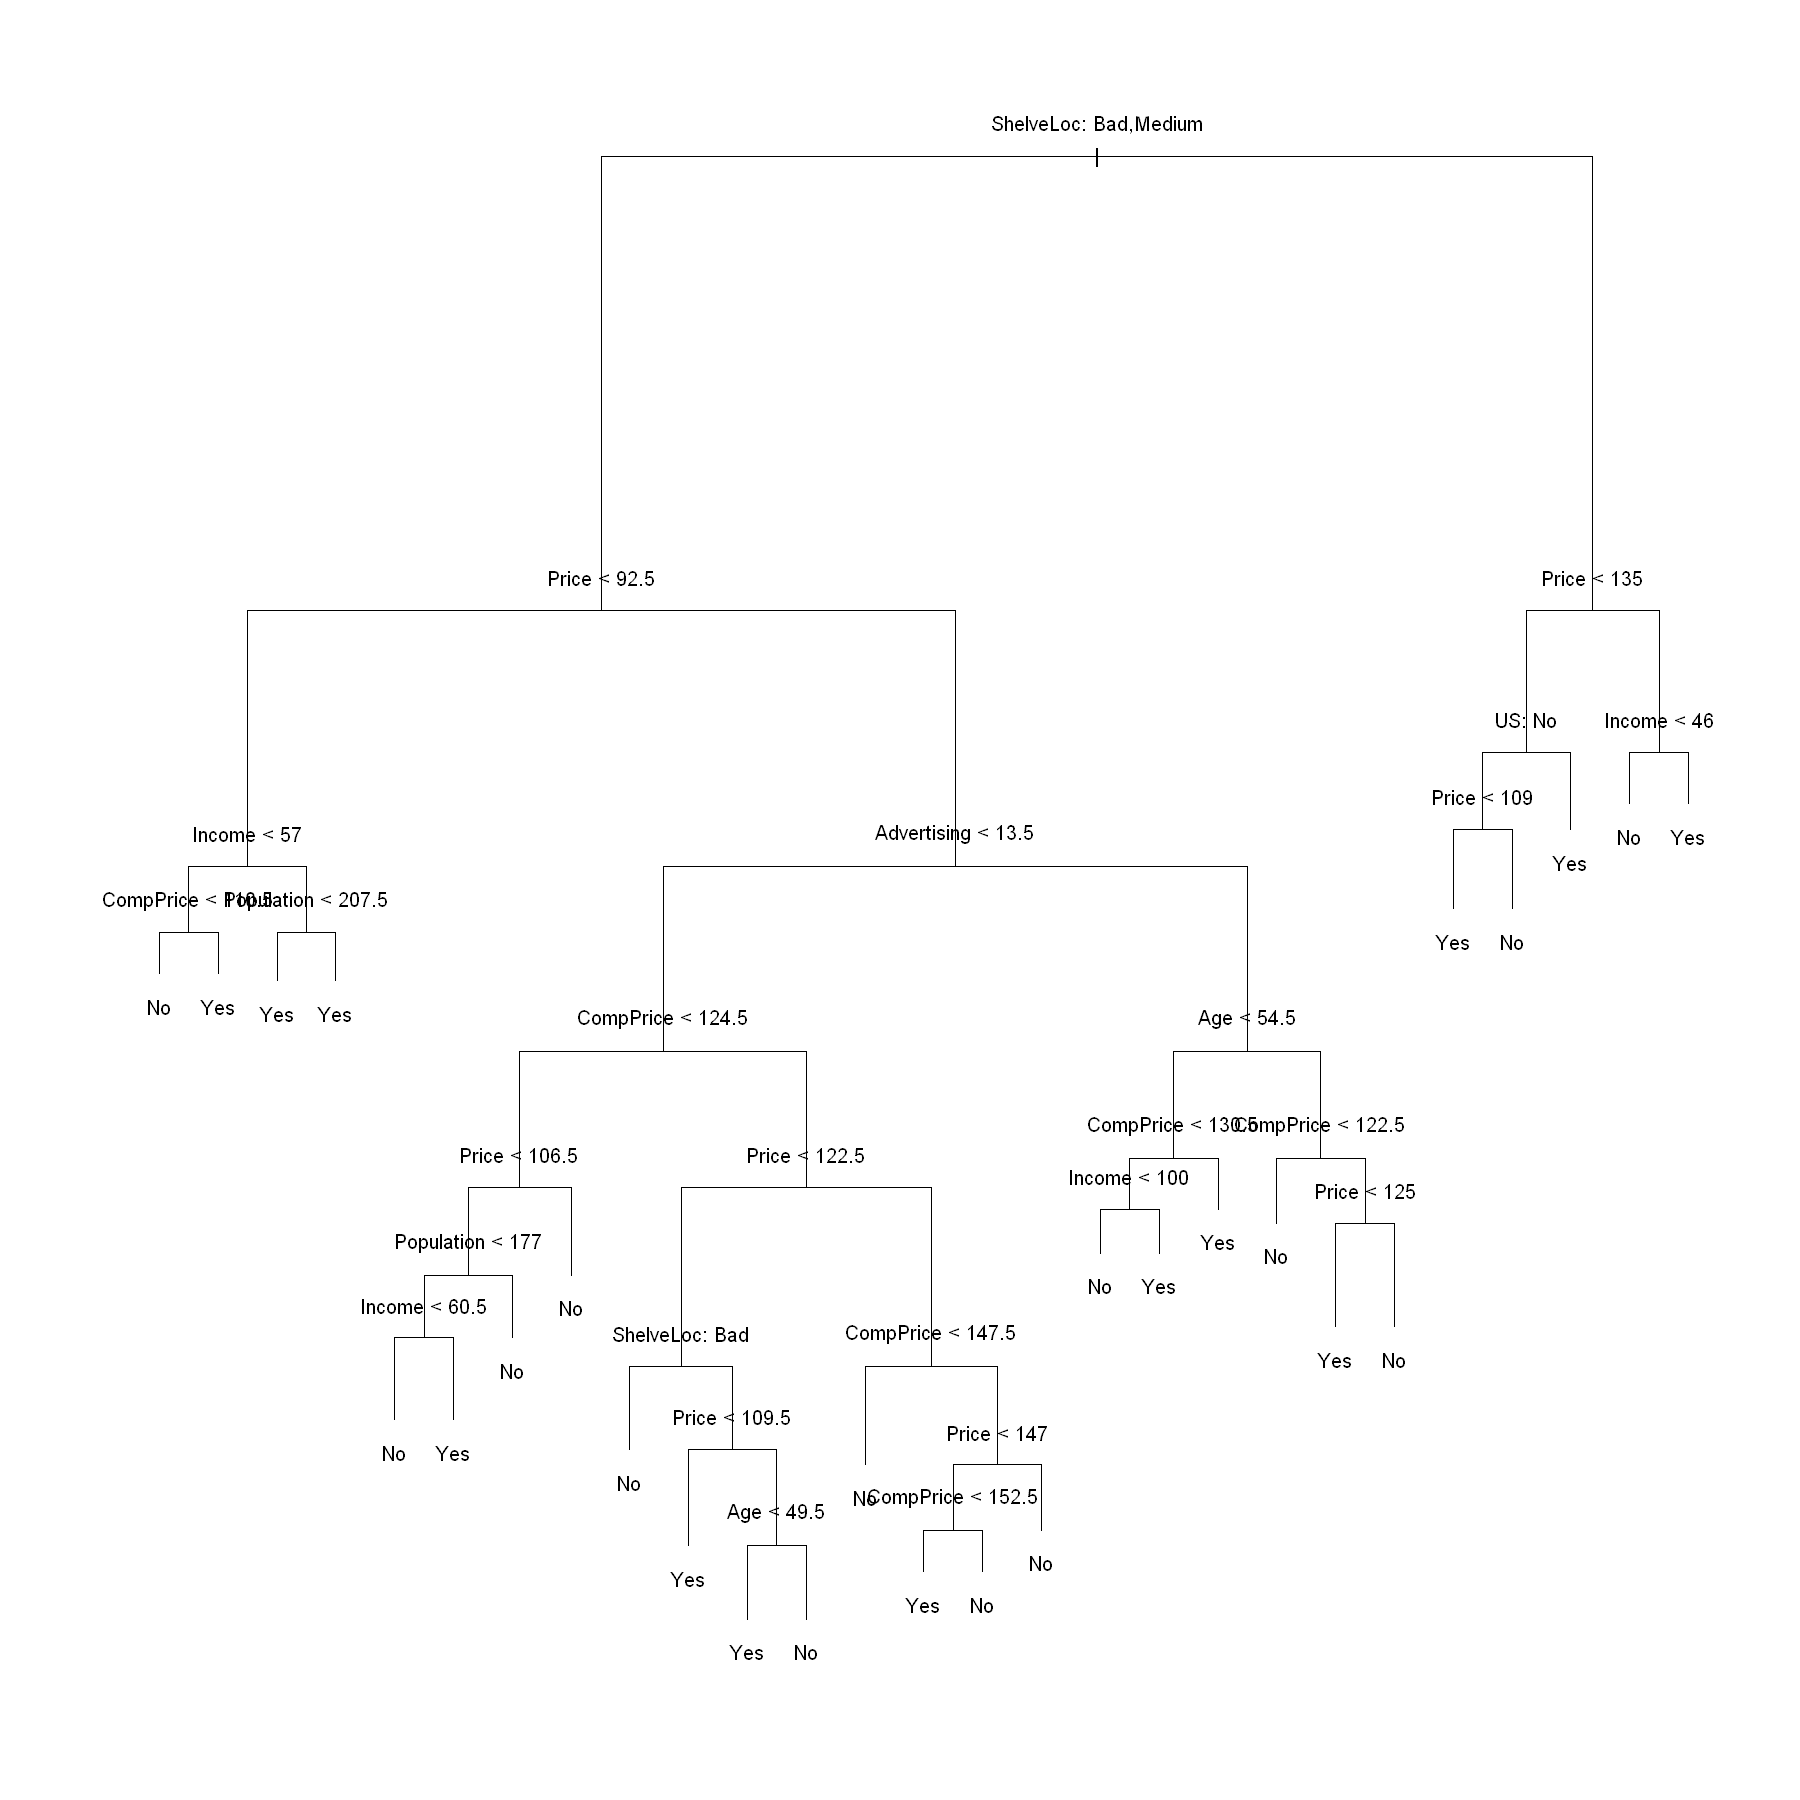

In [81]:
# Show the Decision Tree
options(repr.plot.width=15, repr.plot.height=15)
plot(md_tree)
text(md_tree, pretty=0)

In [82]:
# The Decision Tree model in detailed
# Ref: https://stats.stackexchange.com/questions/6581/what-is-deviance-specifically-in-cart-rpart
md_tree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

**Q1:** Build and evaluate the Decision Tree model with train (first 200 obs) / test (last 200 obs) set.

In [83]:
# Separate train/test
set.seed(2)
train_idx <- sample(1:nrow(cs), 200)
train <- cs[train_idx, ]
test <- cs[-train_idx, ]

In [84]:
# Fit Decision Tree on train dataset
md_tree <- tree(High ~ ., data=train)
summary(md_tree)


Classification tree:
tree(formula = High ~ ., data = train)
Variables actually used in tree construction:
[1] "Price"       "Population"  "ShelveLoc"   "Age"         "Education"  
[6] "CompPrice"   "Advertising" "Income"      "US"         
Number of terminal nodes:  21 
Residual mean deviance:  0.5543 = 99.22 / 179 
Misclassification error rate: 0.115 = 23 / 200 

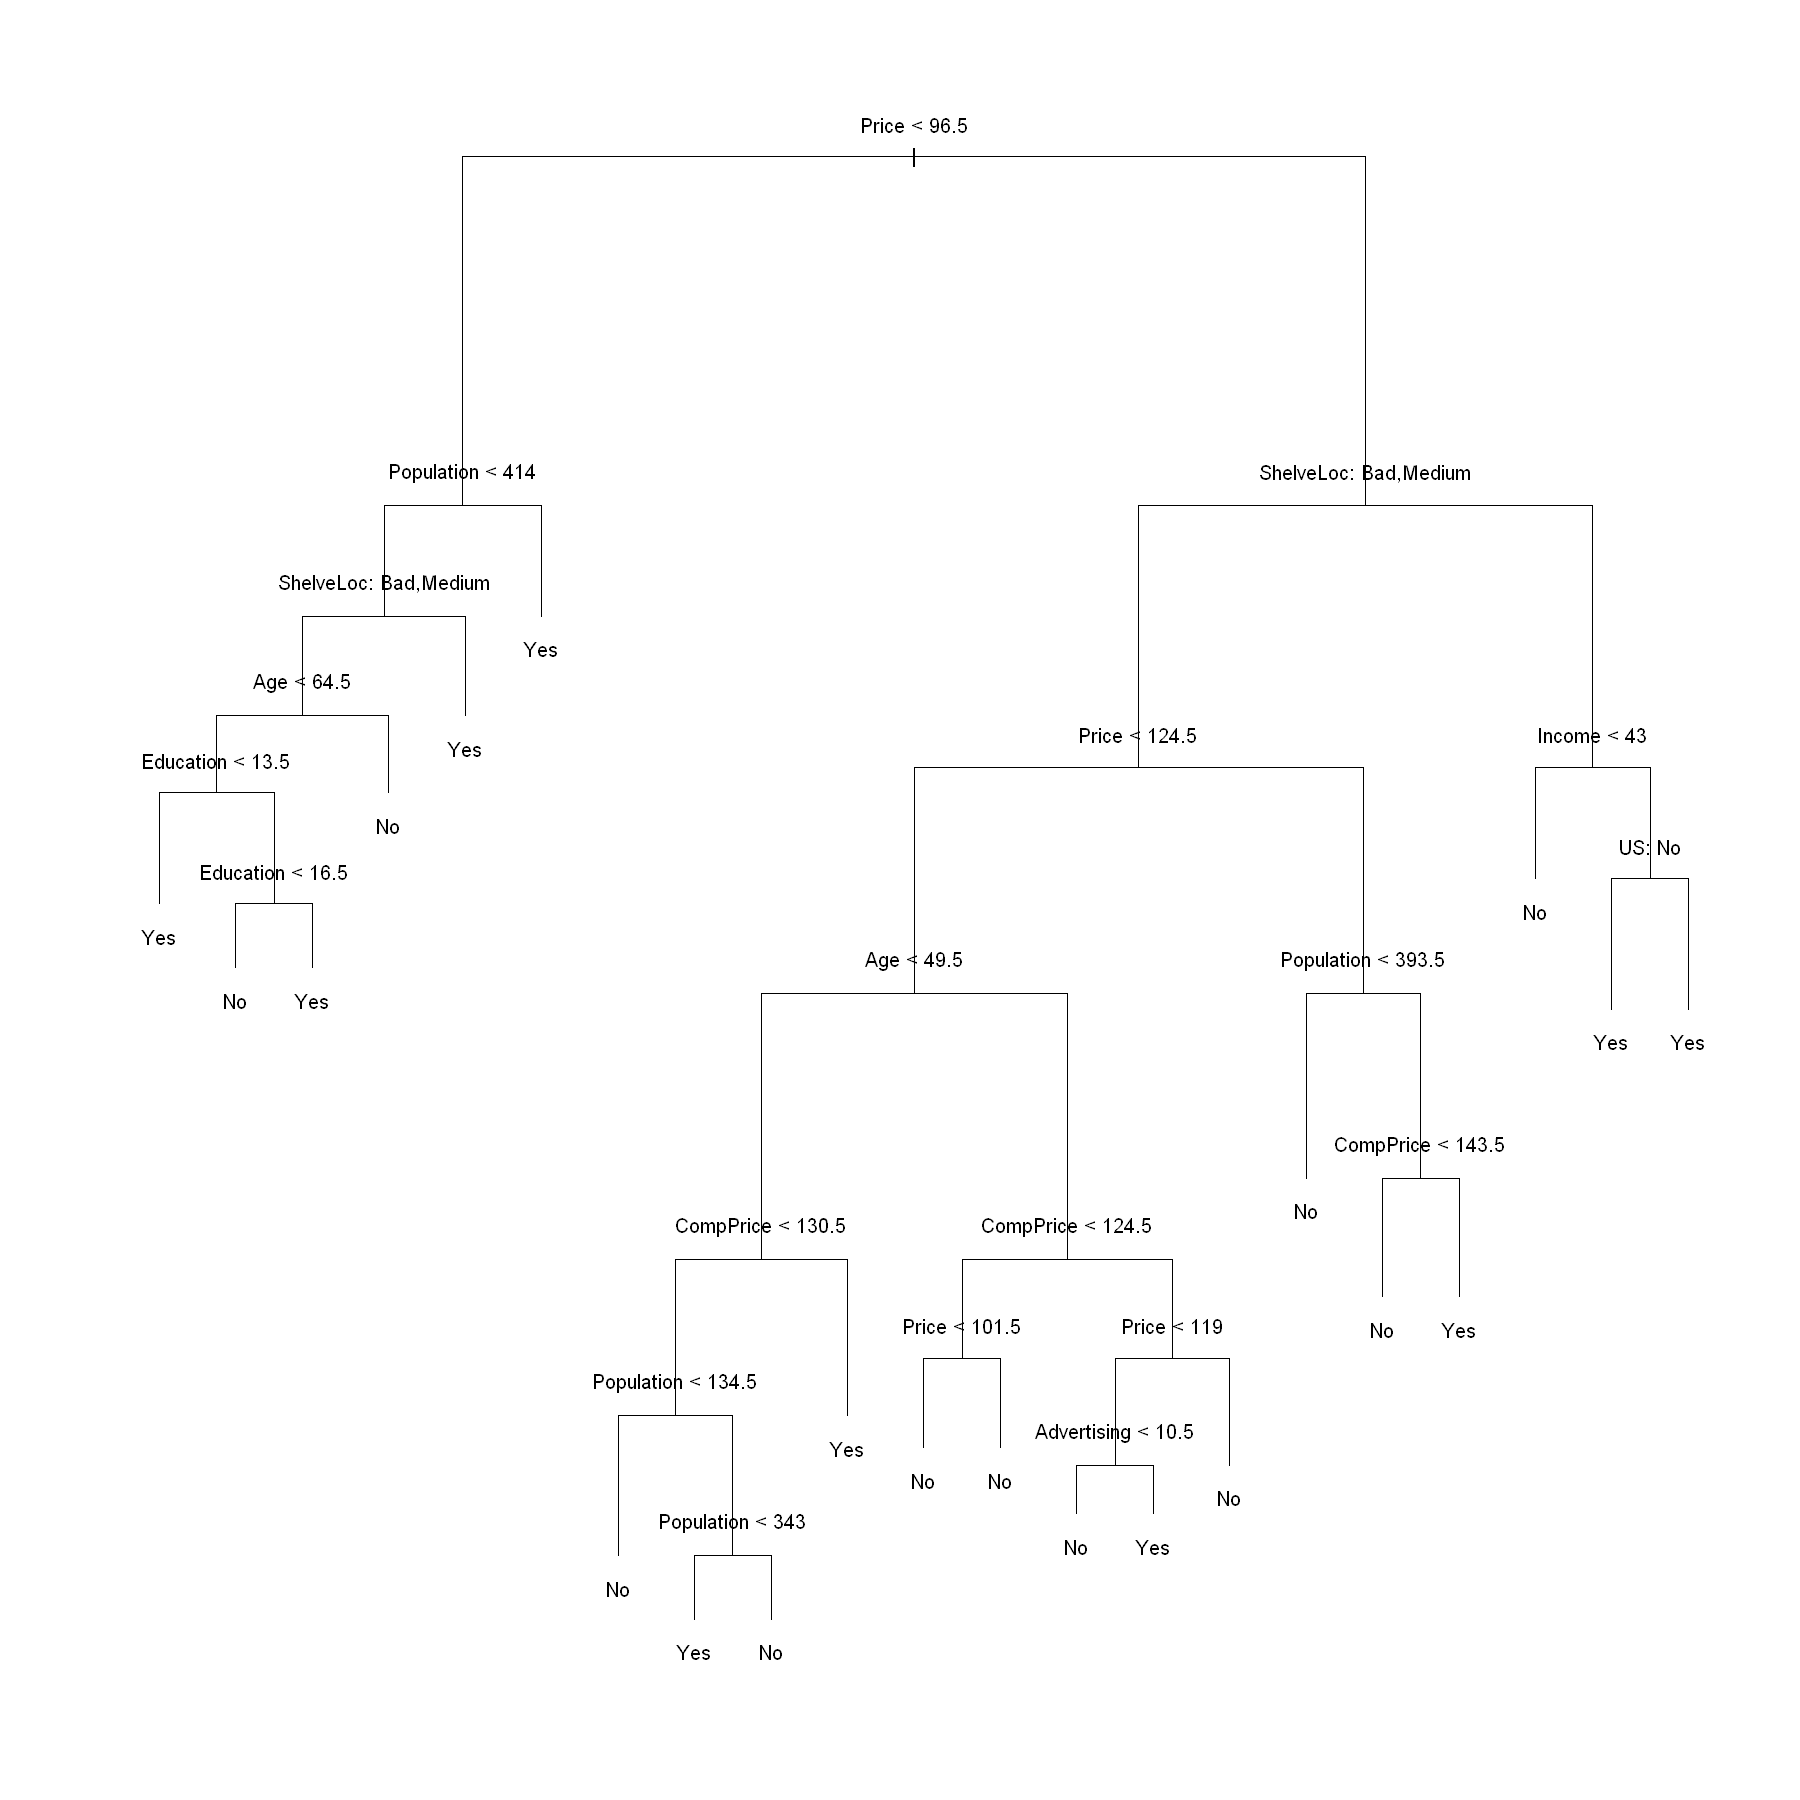

In [85]:
# Show the Decision Tree
options(repr.plot.width=15, repr.plot.height=15)
plot(md_tree)
text(md_tree, pretty=0)

In [86]:
# Make the prediction
set.seed(2)  # Fixed 50:50 class
pred <- predict(md_tree, newdata=test, type='class')
pred_proba <- predict(md_tree, newdata=test, type='vector')[, 'Yes']

# Evaluation: confusion matrix
table(pred, test$High)

# Accuracy
print(paste0('Acuracy = ', mean(pred == test$High)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$High, pred_proba))))

     
pred   No Yes
  No  103  31
  Yes  14  52

[1] "Acuracy = 0.775"


Setting levels: control = No, case = Yes
Setting direction: controls < cases


[1] "AUC = 0.803315827412213"


**Q2:** Prune the Decision Tree model at Q1. Does it perform better?

In [87]:
# Prune the previous tree using error rate
set.seed(3)
cv_cs <- tree::cv.tree(md_tree, FUN=prune.misclass, K=10)
cv_cs

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 74 76 81 81 75 77 78 85 81

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

In [88]:
# Best tree size
min_idx <- which.min(cv_cs$dev)
tree_size <- cv_cs$size[min_idx]
tree_dev <- cv_cs$dev[min_idx]
tree_k <- cv_cs$k[min_idx]

print(paste0('Best tree size = ', tree_size))
print(paste0('Best Error = ', tree_dev))
print(paste0('Best alpha = ', tree_k))

[1] "Best tree size = 21"
[1] "Best Error = 74"
[1] "Best alpha = -Inf"


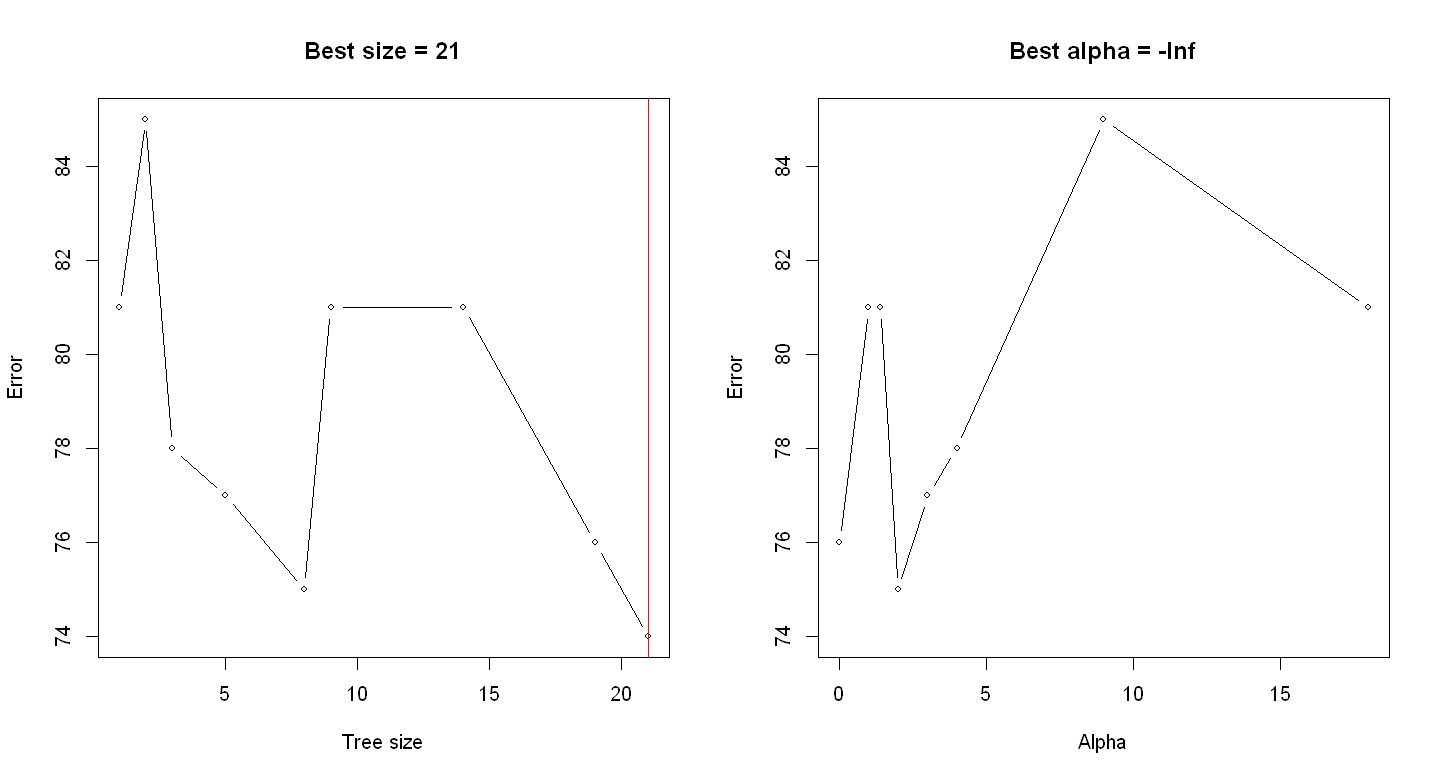

In [89]:
# Show the Decision Tree
options(repr.plot.width=12, repr.plot.height=6.5)
par(mfrow=c(1, 2))

# Tree size, number of nodes
plot(cv_cs$size, cv_cs$dev, type='b', cex=0.7,
     xlab='Tree size', ylab='Error',
     main=paste0('Best size = ', tree_size)
    )
abline(v=tree_size, col='red')  # Best tree size

# Cost-complexity param, alpha
plot(cv_cs$k, cv_cs$dev, type='b', cex=0.7,
     xlab='Alpha', ylab='Error',
     main=paste0('Best alpha = ', round(tree_k, 3))
    )
abline(v=tree_k, col='red')

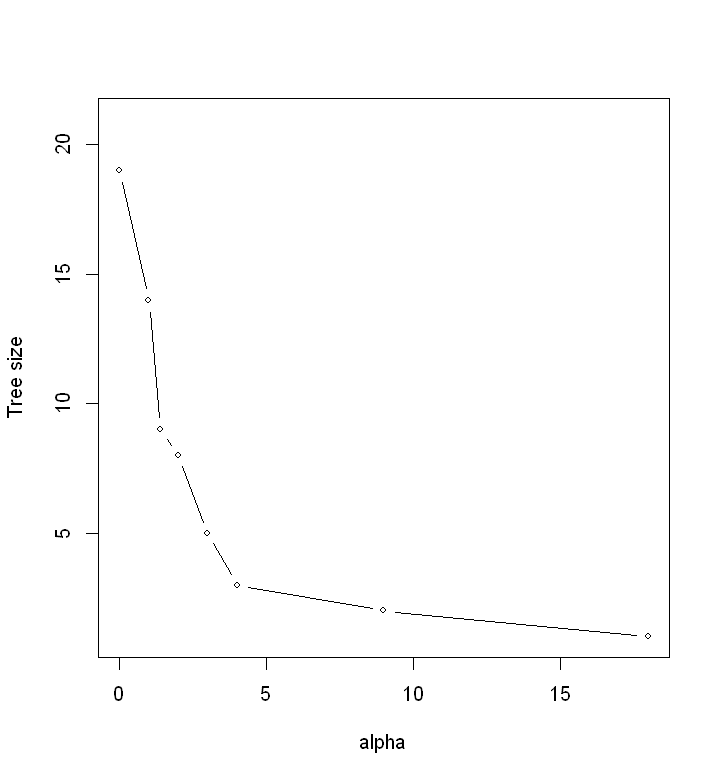

In [90]:
# Show the relationship between alpha and tree size
options(repr.plot.width=6, repr.plot.height=6.5)
plot(cv_cs$k, cv_cs$size, type='b', cex=0.7,
     xlab='alpha', ylab='Tree size'
    )

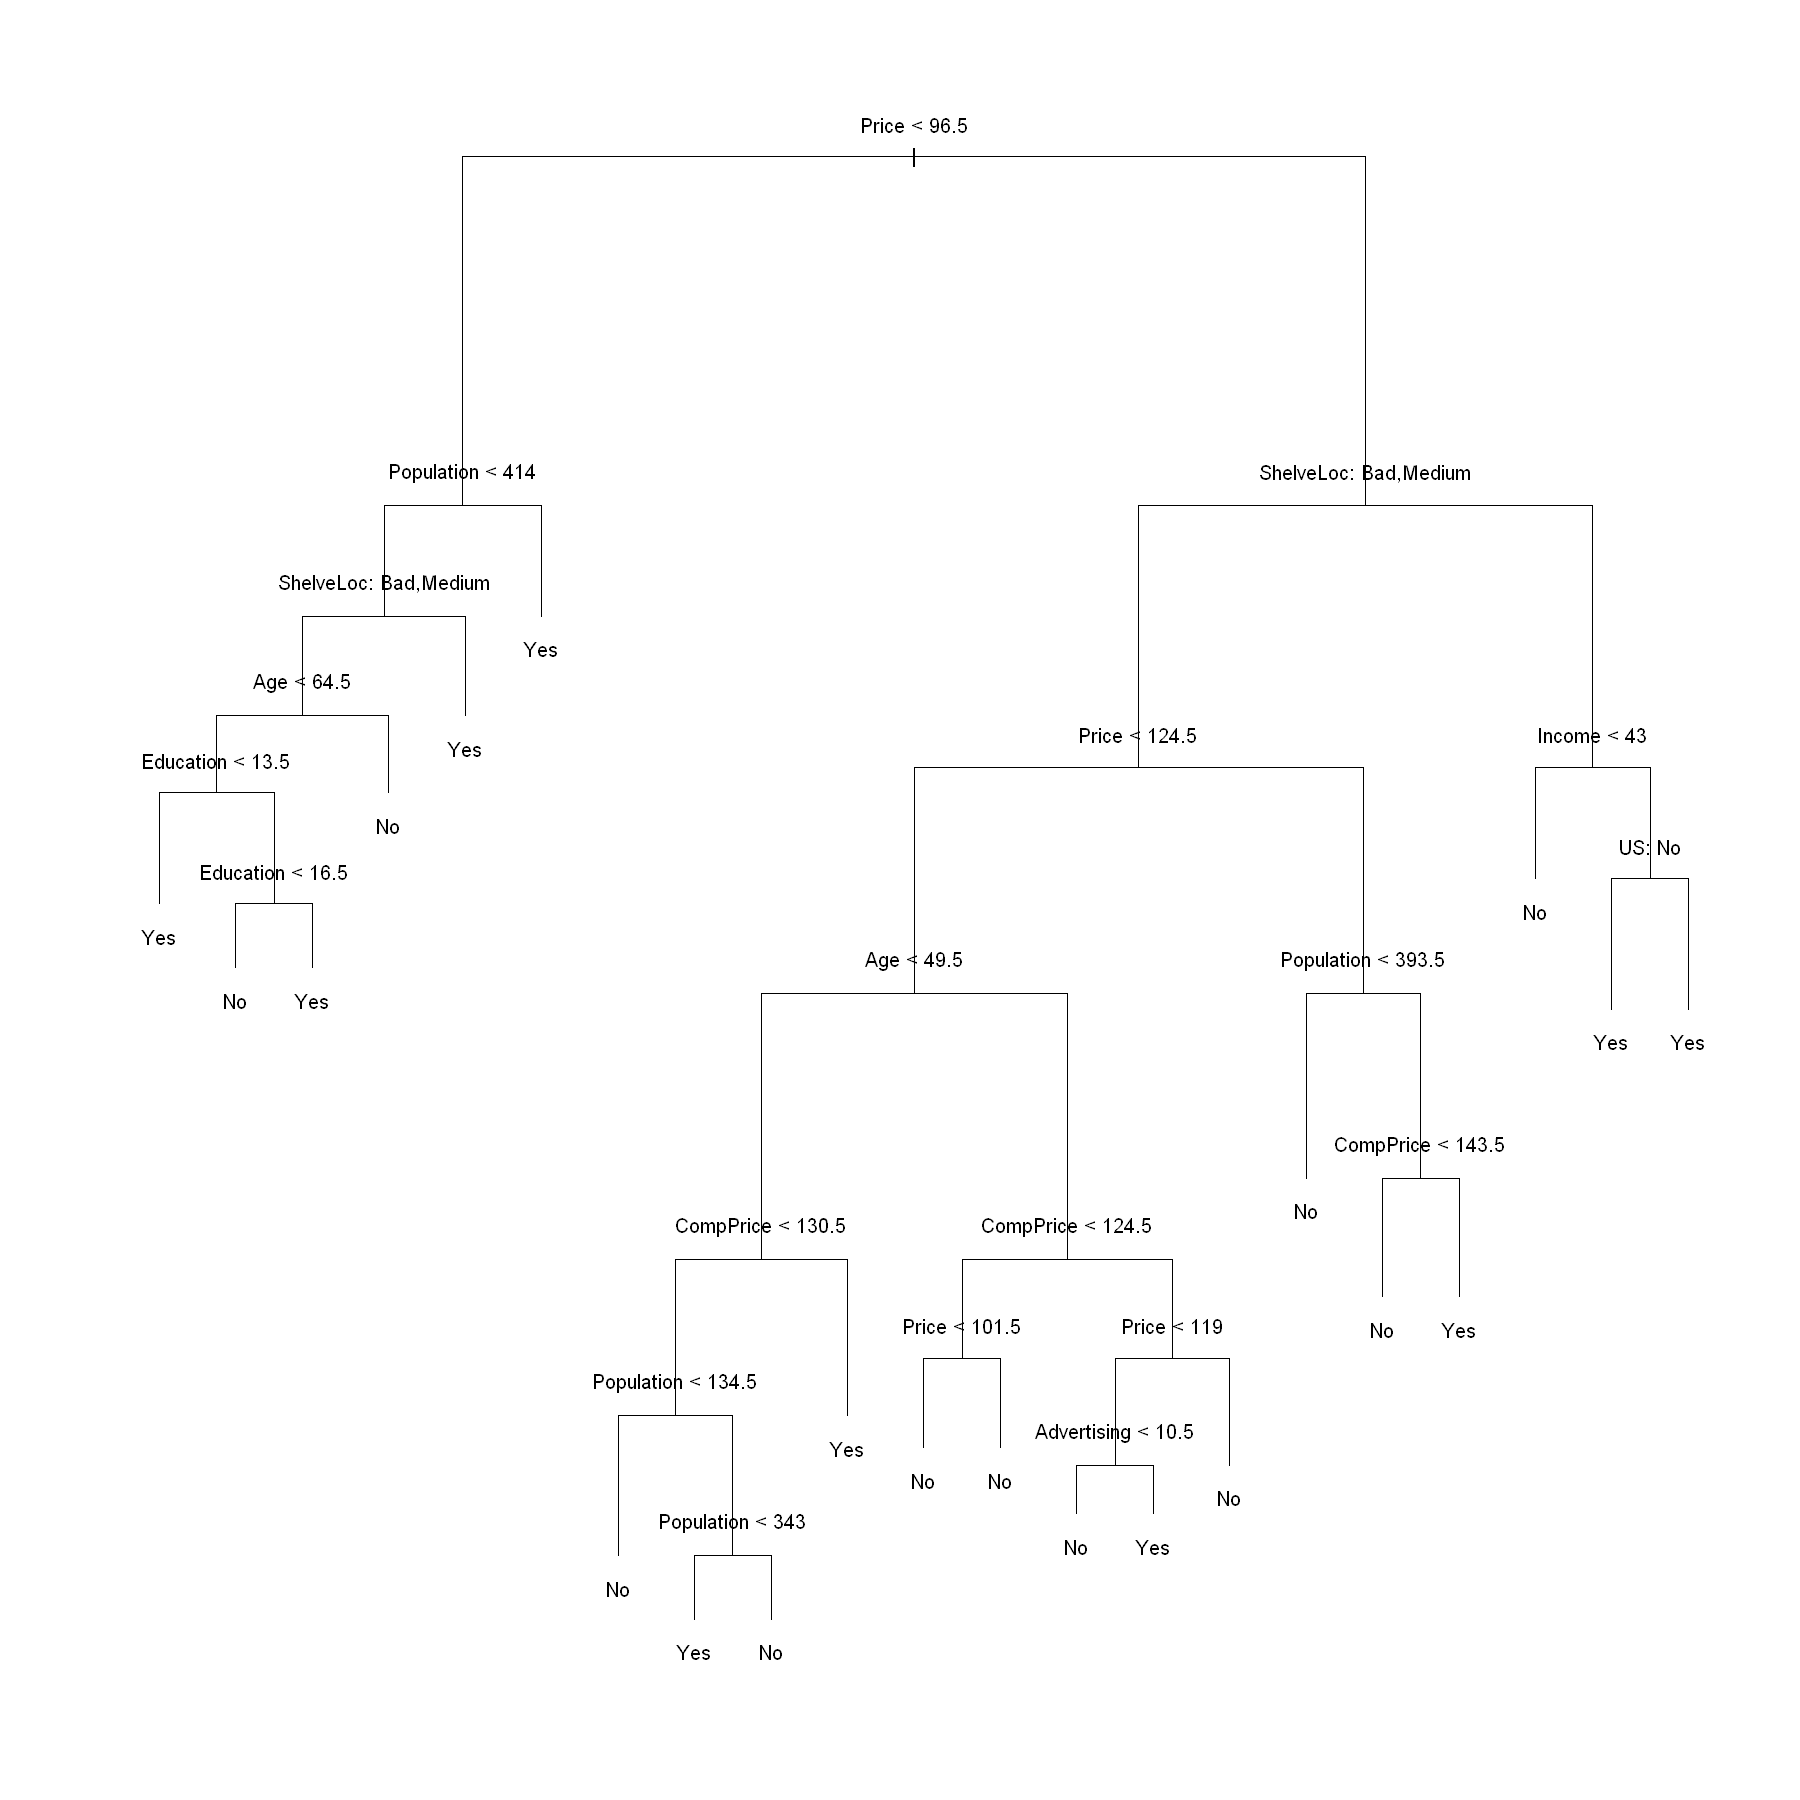

In [91]:
# Prune the tree
prune_tree <- prune.misclass(md_tree, best=tree_size)

# Show the tree
options(repr.plot.width=15, repr.plot.height=15)
plot(prune_tree)
text(prune_tree, pretty=0)

In [92]:
# Check the performance of the pruned tree
set.seed(1)  # Fixed 50:50 class
pred_pruned <- predict(prune_tree, newdata=test, type='class')
pred_pruned_proba <- predict(prune_tree, newdata=test, type='vector')[, 'Yes']

# Evaluation: confusion matrix
table(pred_pruned, test$High)

# Accuracy
print(paste0('Accuracy = ', mean(pred_pruned == test$High)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$High, pred_pruned_proba))))

           
pred_pruned  No Yes
        No  103  33
        Yes  14  50

[1] "Accuracy = 0.765"


Setting levels: control = No, case = Yes
Setting direction: controls < cases


[1] "AUC = 0.803315827412213"


### Lab 2: Cars Sales Data - Regression Tree

- Q1: Build and evaluate the Regression Tree model with train/test (50:50) set.
- Q2: Prune and evaluate Regression Tree at Q1. Does it peform better?

#### Import, explore and prepare data

In [93]:
# Load require packages
library(tree)  # Regression and classification tree
library(MASS)  # Housing dataset

Warning message:
"package 'MASS' was built under R version 3.6.3"

In [94]:
# Load and explore the dataset
# crim: per capita crime rate by town
# zn: proportion of residential land zoned for lots over 25,000 sq.ft.
# indus: proportion of non-retail business acres per town.
# chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
# nox: nitrogen oxides concentration (parts per 10 million).
# rm: average number of rooms per dwelling.
# age: proportion of owner-occupied units built prior to 1940.
# dis: weighted mean of distances to five Boston employment centres.
# rad: index of accessibility to radial highways.
# tax: full-value property-tax rate per \$10,000.
# ptratio: pupil-teacher ratio by town.
# black: 1000(Bk − 0.63)^2 where Bk is the proportion of blacks by town.
# lstat: lower status of the population (percent).
# medv: median value of owner-occupied homes in $1000s.
bt <- MASS::Boston
str(bt)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


In [95]:
# Check NAs
apply(is.na(bt), 2, sum)

crim      zn   indus    chas     nox      rm     age     dis     rad     tax 
      0       0       0       0       0       0       0       0       0       0 
ptratio   black   lstat    medv 
      0       0       0       0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   17.02   21.20   22.53   25.00   50.00 

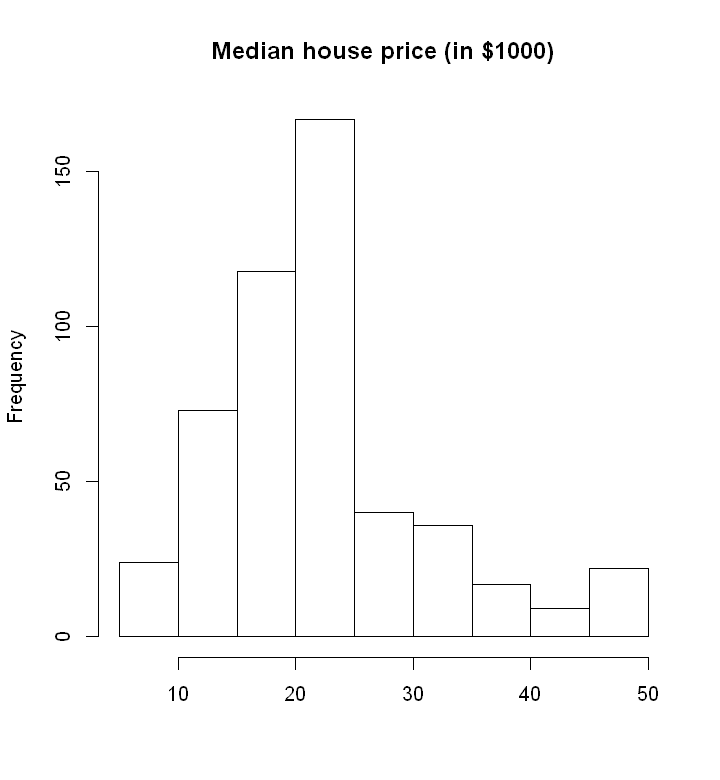

In [96]:
# Check the target variable: median house price
summary(bt$medv)

options(repr.plot.width=6, repr.plot.height=6.5)
hist(bt$medv,
     main='Median house price (in $1000)', xlab='')

**Q1:** Build and evaluate the Regression Tree model with train/test (50:50) set.

In [97]:
# Separate train/test
set.seed(1)
train_idx <- sample(1:nrow(bt), nrow(bt) / 2)
train <- bt[train_idx, ]
test <- bt[-train_idx, ]

In [98]:
# Fit Decision Tree on train dataset
md_rtree <- tree(medv ~ ., data=train)
summary(md_rtree)


Regression tree:
tree(formula = medv ~ ., data = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

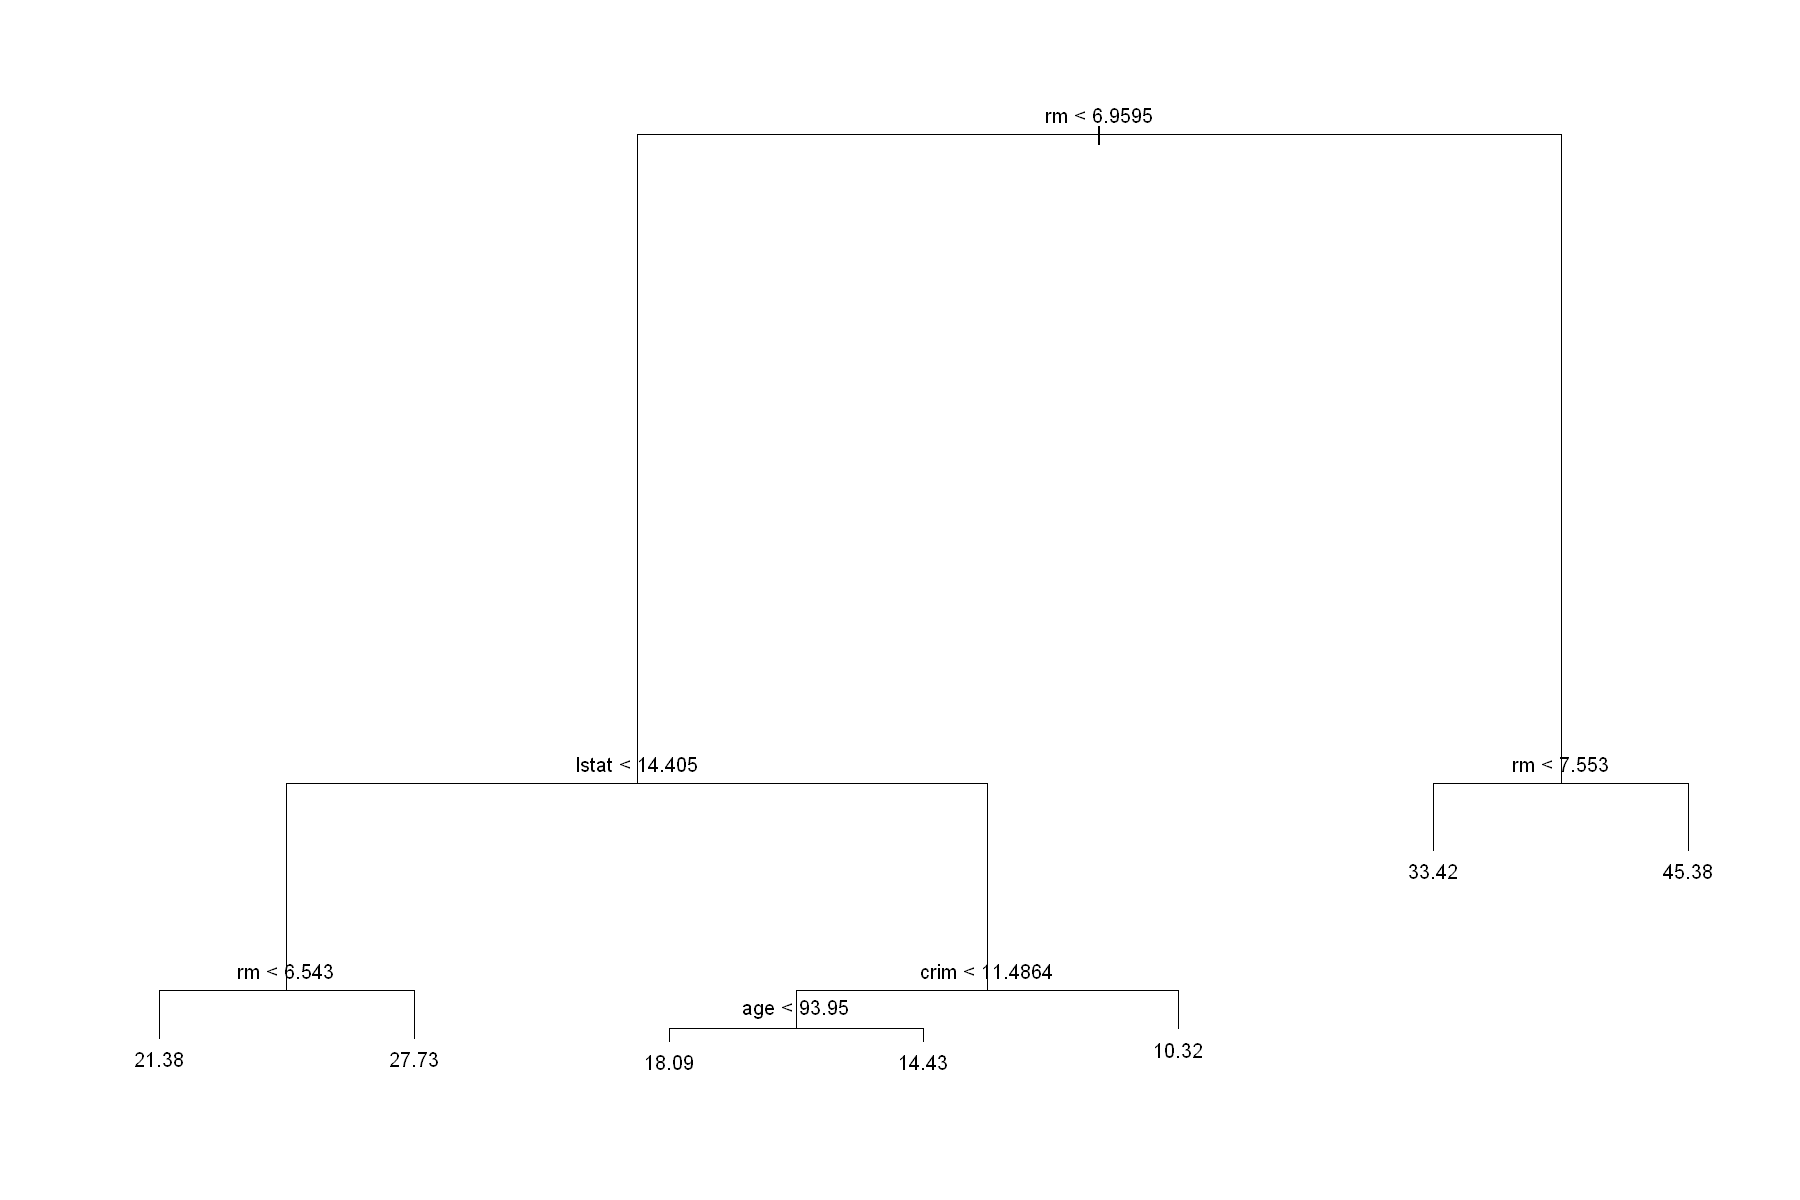

In [99]:
# Show the Decision Tree
options(repr.plot.width=15, repr.plot.height=10)
plot(md_rtree)
text(md_rtree, pretty=0)

In [100]:
# Make the prediction
pred <- predict(md_rtree, newdata=test)

# Evaluation: MSE
mean((pred - test$medv) ^ 2)

[1] 35.28688

**Q2:** Prune and evaluate Regression Tree at Q1. Does it peform better?

In [101]:
# Prune the previous tree using error rate
set.seed(3)
cv_bt <- cv.tree(md_rtree)
cv_bt

$size
[1] 7 6 5 4 3 2 1

$dev
[1]  4226.314  4238.911  5132.175  6075.025  6601.868  9898.635 19638.228

$k
[1]       -Inf   203.9641   637.2707   796.1207  1106.4931  3424.7810 10724.5951

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

In [102]:
# Best tree size
min_idx <- which.min(cv_bt$dev)
tree_size <- cv_bt$size[min_idx]
tree_dev <- cv_bt$dev[min_idx]
tree_k <- cv_bt$k[min_idx]

print(paste0('Best tree size = ', tree_size))
print(paste0('Best Error = ', tree_dev))
print(paste0('Best alpha = ', tree_k))

[1] "Best tree size = 7"
[1] "Best Error = 4226.31379712386"
[1] "Best alpha = -Inf"


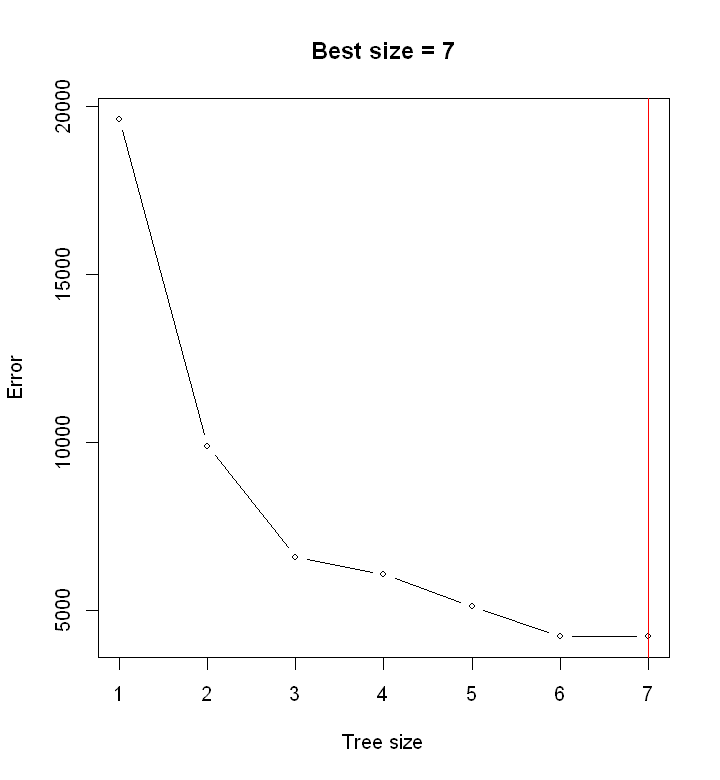

In [103]:
# Show the relationship between the size and the error of the tree
options(repr.plot.width=6, repr.plot.height=6.5)
plot(cv_bt$size, cv_bt$dev, type='b', cex=0.7,
     main=paste0('Best size = ', tree_size),
     ylab='Error', xlab='Tree size'
    )  # Tree size, number of nodes
abline(v=tree_size, col='red')  # Best tree size

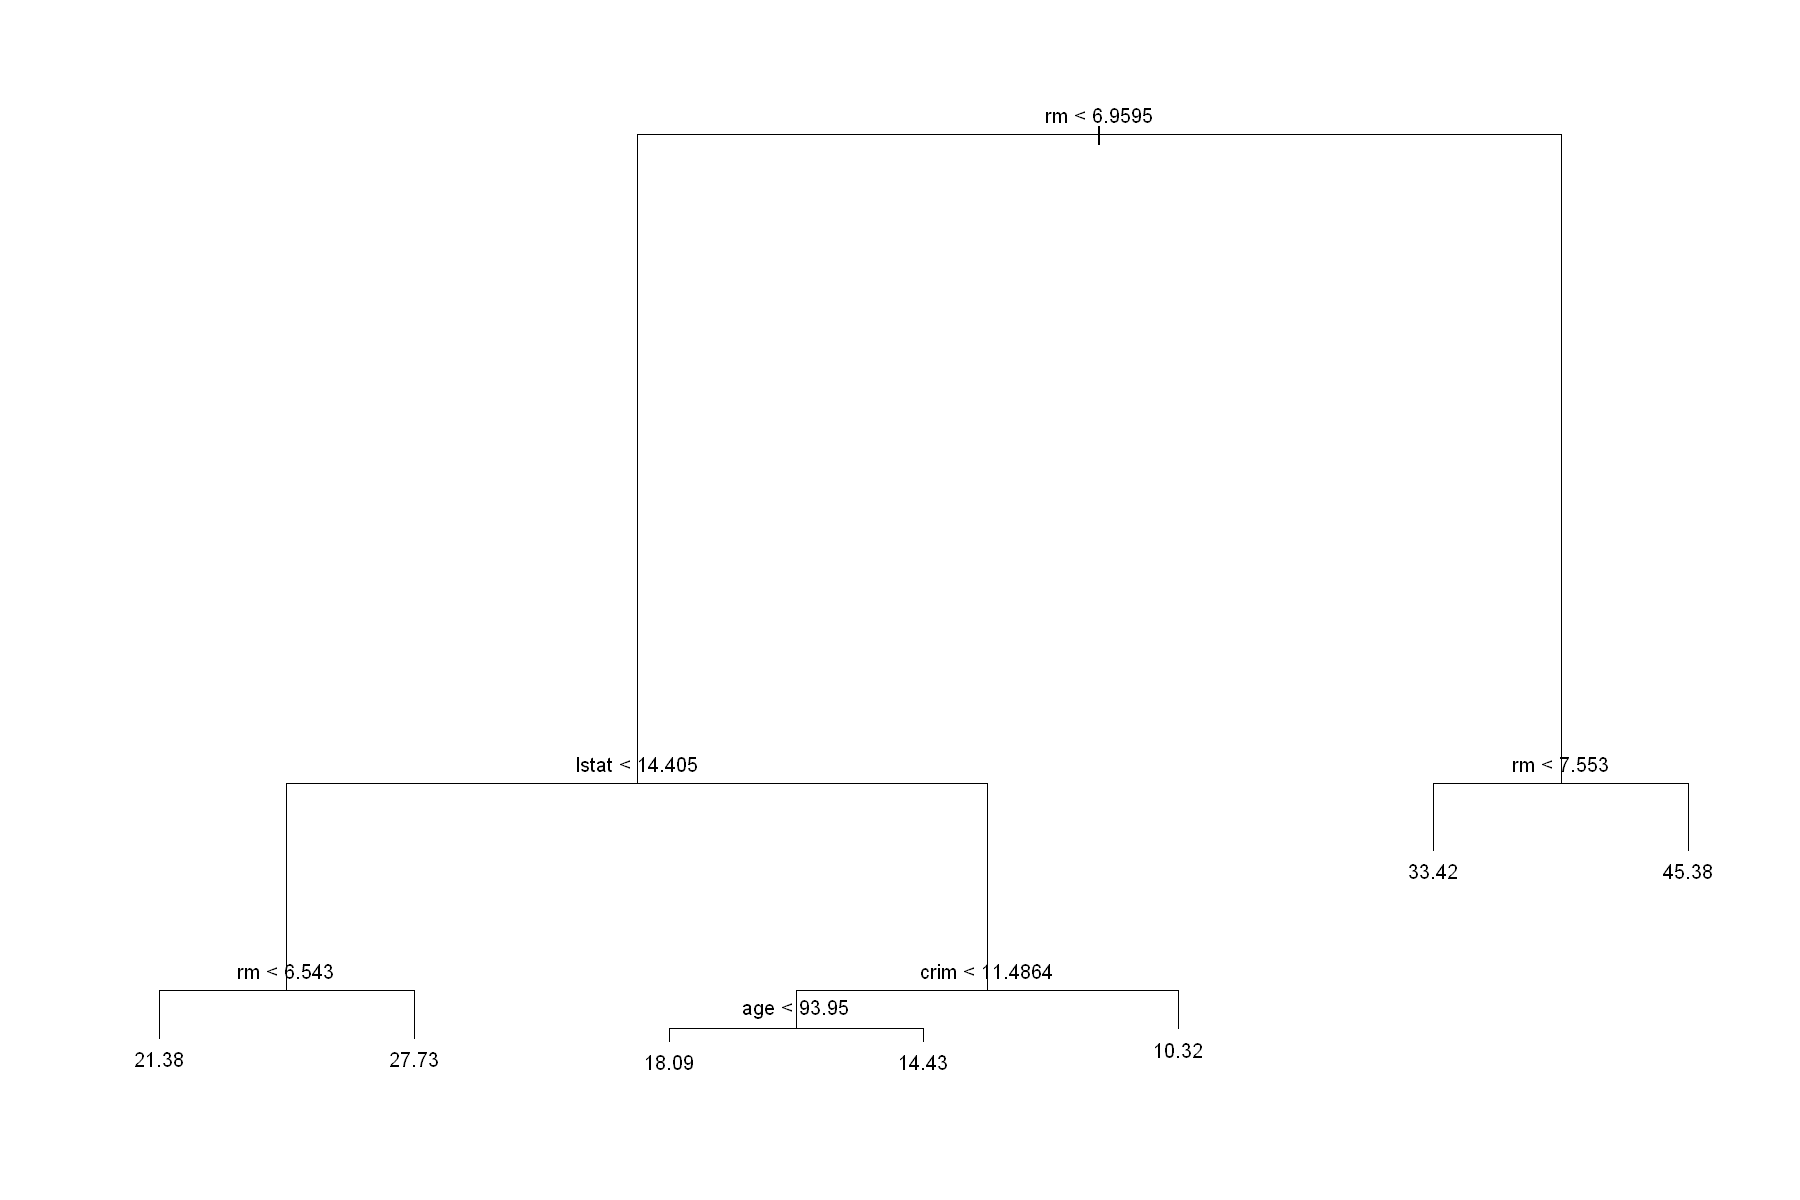

In [104]:
# Prune the tree
prune_rtree <- prune.tree(md_rtree, best=tree_size)

# Show the tree
options(repr.plot.width=15, repr.plot.height=10)
plot(prune_rtree)
text(prune_rtree, pretty=0)

In [105]:
# Check the performance of the pruned tree
pred_pruned <- predict(prune_rtree, newdata=test)

# Evaluation: MSE
mean((pred_pruned - test$medv) ^ 2)

[1] 35.28688

### Lab 3: Boston Housing Data - Bagging and Random Forests

- Q1: Train a Bagging Regression Tree model. Compare it performance with the Decision Tree model.
- Q2: Train a Random Forests model. Compare it performance with the Decision Tree and Bagging Tree model.
- Q3: Extract the variable importance of Random Forests model. Which variables are most important?

#### Import, explore and prepare data

In [106]:
# Load required libaries and data
library(randomForest)  # Random Forests model
library(MASS)  # Boston housing data

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [107]:
# Import data
# crim: per capita crime rate by town
# zn: proportion of residential land zoned for lots over 25,000 sq.ft.
# indus: proportion of non-retail business acres per town.
# chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
# nox: nitrogen oxides concentration (parts per 10 million).
# rm: average number of rooms per dwelling.
# age: proportion of owner-occupied units built prior to 1940.
# dis: weighted mean of distances to five Boston employment centres.
# rad: index of accessibility to radial highways.
# tax: full-value property-tax rate per \$10,000.
# ptratio: pupil-teacher ratio by town.
# black: 1000(Bk − 0.63)^2 where Bk is the proportion of blacks by town.
# lstat: lower status of the population (percent).
# medv: median value of owner-occupied homes in $1000s.
house <- MASS::Boston
str(house)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


In [108]:
# Separate train/test
set.seed(1)
train_idx <- sample(1:nrow(house), nrow(house) / 2)
train <- bt[train_idx, ]
test <- bt[-train_idx, ]

**Q1:** Train a Bagging Regression Tree model. Compare it performance with the Decision Tree model.

In [109]:
# Fit bagging model, use all predictors
md_bagtree <- randomForest(medv ~ ., data=train, mtry=13, importance=T)
md_bagtree


Call:
 randomForest(formula = medv ~ ., data = train, mtry = 13, importance = T) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.33119
                    % Var explained: 85.26

[1] 23.4579

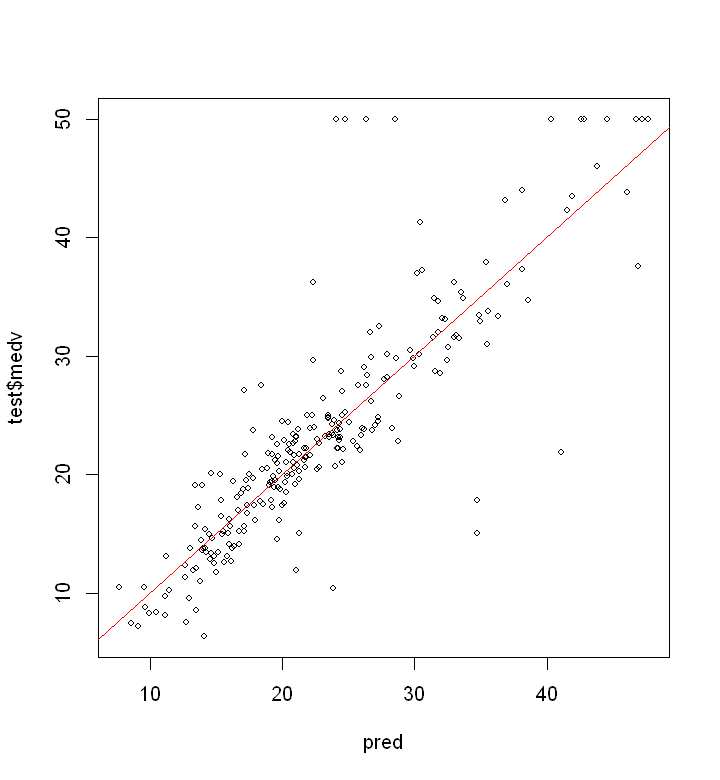

In [110]:
# Make prediction
pred <- predict(md_bagtree, newdata=test)

options(repr.plot.width=6, repr.plot.height=6.5)
plot(pred, test$medv, cex=0.7)
abline(0, 1, col='red')

# MSE
mean((pred - test$medv) ^ 2)

In [111]:
# Fit bagging model with different number of trees
md_bagtree <- randomForest(medv ~ ., data=train, mtry=13, ntree=25, importance=T)
pred <- predict(md_bagtree, newdata=test)

# Evaluation: MSE
mean((pred - test$medv) ^ 2)

[1] 22.79211

**Q2:** Train a Random Forests model. Compare it performance with the Decision Tree and Bagging Tree model.

In [112]:
# Fit random forests model
set.seed(1)
md_rf <- randomForest(medv ~ ., data=train, mtry=6, importance=T)  # Default mtry = p/3
md_rf


Call:
 randomForest(formula = medv ~ ., data = train, mtry = 6, importance = T) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 9.779194
                    % Var explained: 87.28

In [113]:
# Make prediction
pred_rf <- predict(md_rf, newdata=test)

# Evaluation: MSE
mean((pred_rf - test$medv) ^ 2)

[1] 19.62021

**Q3:** Extract the variable importance of Random Forests model. Which variables are most important?

In [114]:
# Feature importance
#importance(md_rf, type=2)
importance(md_rf)

,%IncMSE,IncNodePurity
crim,16.697017,1076.08786
zn,3.625784,88.35342
indus,4.968621,609.53356
chas,1.061432,52.21793
nox,13.518179,709.87339
rm,32.343305,7857.65451
age,13.272498,612.21424
dis,9.032477,714.94674
rad,2.878434,95.80598
tax,9.118801,364.92479


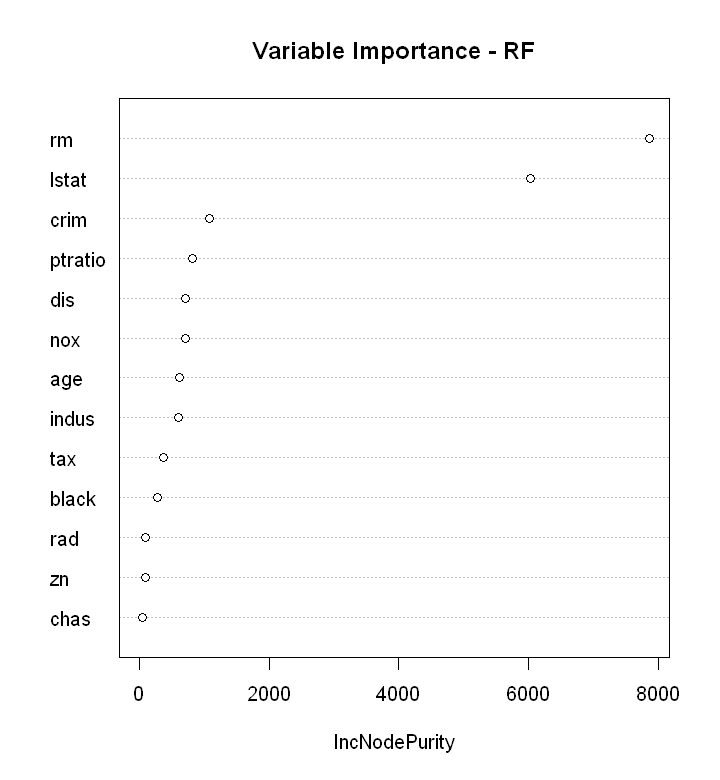

In [115]:
# Plot feature importance
options(repr.plot.width=6, repr.plot.height=6.5)
varImpPlot(md_rf, type=2, main='Variable Importance - RF')

### Lab 4: Boston Housing Data - Boosting Regression Tree

- Q1: Train a Boosting Tree model. Compare it performance with the Decision Tree, Bagging Tree, Random Forests model.
- Q2: Extract the variable importance of Boosting Tree model. Which variables are most important?

#### Import, explore and prepare data

In [116]:
# Load required libaries and data
library(gbm)  # Boosting library
library(MASS)  # Boston housing data

ERROR: Error in library(gbm): there is no package called 'gbm'


In [117]:
# Import data
# crim: per capita crime rate by town
# zn: proportion of residential land zoned for lots over 25,000 sq.ft.
# indus: proportion of non-retail business acres per town.
# chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
# nox: nitrogen oxides concentration (parts per 10 million).
# rm: average number of rooms per dwelling.
# age: proportion of owner-occupied units built prior to 1940.
# dis: weighted mean of distances to five Boston employment centres.
# rad: index of accessibility to radial highways.
# tax: full-value property-tax rate per \$10,000.
# ptratio: pupil-teacher ratio by town.
# black: 1000(Bk − 0.63)^2 where Bk is the proportion of blacks by town.
# lstat: lower status of the population (percent).
# medv: median value of owner-occupied homes in $1000s.
house <- MASS::Boston
str(house)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


In [118]:
# Separate train/test
set.seed(1)
train_idx <- sample(1:nrow(house), nrow(house) / 2)
train <- bt[train_idx, ]
test <- bt[-train_idx, ]

**Q1:** Train a Boosting Tree model. Compare it performance with the Decision Tree, Bagging Tree, Random Forests model.

In [119]:
# Fit boosting regression tree
set.seed(1)
md_boosttree <- gbm(medv ~ ., data=train,
                    distribution='gaussian',
                    n.trees=5000,  # Number of boosting iteration
                    interaction.depth=4)  # Maximum nodes per tree

ERROR: Error in gbm(medv ~ ., data = train, distribution = "gaussian", n.trees = 5000, : could not find function "gbm"


In [120]:
# Make prediction
pred <- predict(md_boosttree, newdata=test, n.trees=5000)

# MSE
mean((pred - test$medv) ^ 2)

ERROR: Error in predict(md_boosttree, newdata = test, n.trees = 5000): object 'md_boosttree' not found


In [121]:
# Fit boosting model with different shrinkage param, default alpha = 0.001
set.seed(3)
md_boosttree <- gbm(medv ~ ., data=train, distribution='gaussian',
                    n.trees=5000, interaction.depth=4, shrinkage=0.01,
                    verbose=F)

# Make prediction
pred <- predict(md_boosttree, newdata=test, n.trees=5000)

# Evaluation: MSE
mean((pred - test$medv) ^ 2)

ERROR: Error in gbm(medv ~ ., data = train, distribution = "gaussian", n.trees = 5000, : could not find function "gbm"


**Q2:** Extract the variable importance of Boosting Tree model. Which variables are most important?

In [122]:
options(repr.plot.width=6, repr.plot.height=6.5)
summary(md_boosttree)

ERROR: Error in summary(md_boosttree): object 'md_boosttree' not found


In [123]:
# Partial dependence plots
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(2, 1))
plot(md_boosttree, i='rm')
plot(md_boosttree, i='lstat')

ERROR: Error in plot(md_boosttree, i = "rm"): object 'md_boosttree' not found


## Homework
- Exercise 3 (p.332, Chap.8), 5 (p.332, Chap.8), 8 (p.333, Chap.8), 9 (p.334, Chap.8) and 10 (p.334, Chap.8)

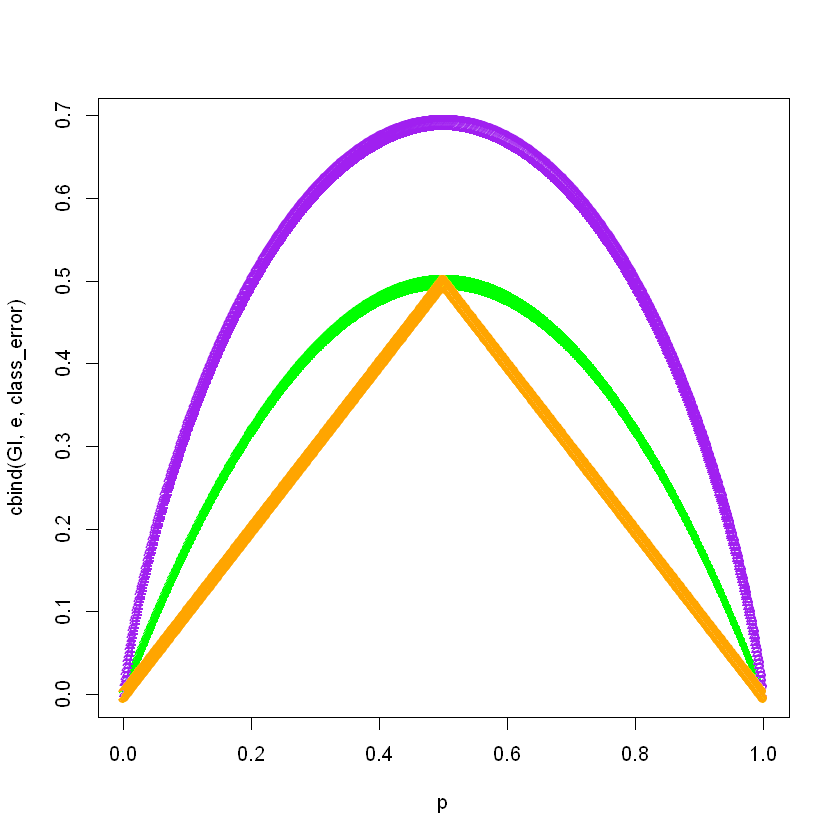

In [1]:
#EXERCISE 3, CHAPTER 8

p <- seq(0, 1, 0.001)
GI <- 2 * p * (1 - p)
class_error <- 1 - pmax(p, 1 - p)
e <- - (p * log(p) + (1 - p) * log(1 - p))
matplot(p, cbind(GI, e, class_error), col = c("green", "purple", "orange"))


In [2]:
#EXERCISE 5, CHAPTER 8

#Final classification for majority vote is red glasses and final classification 
#for the average probability method is green glasses.




[1] 4.395357

[1] 4.658628

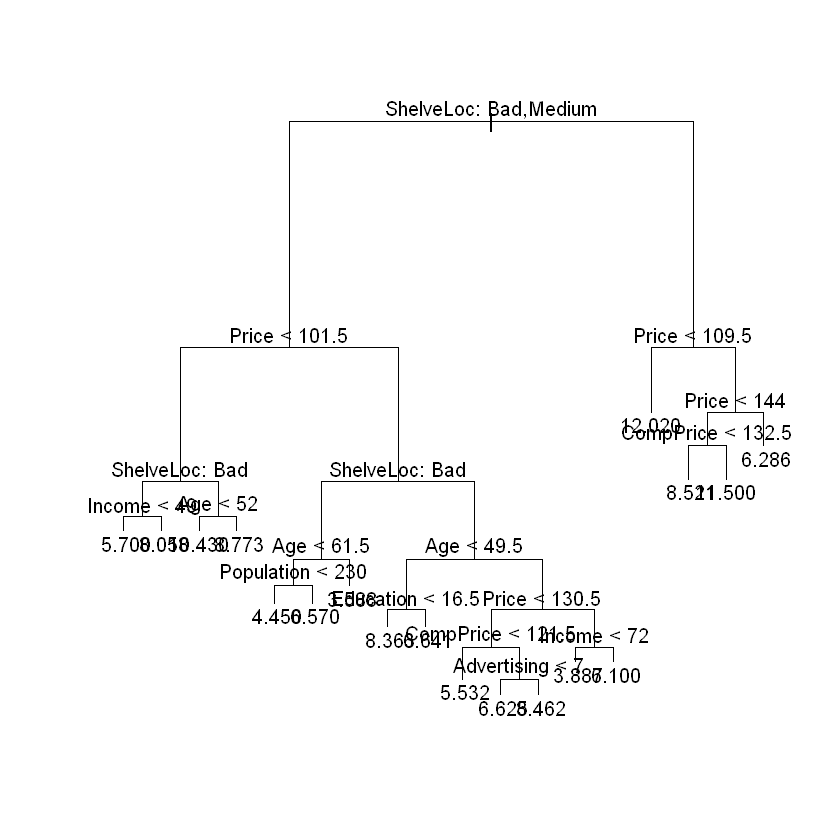

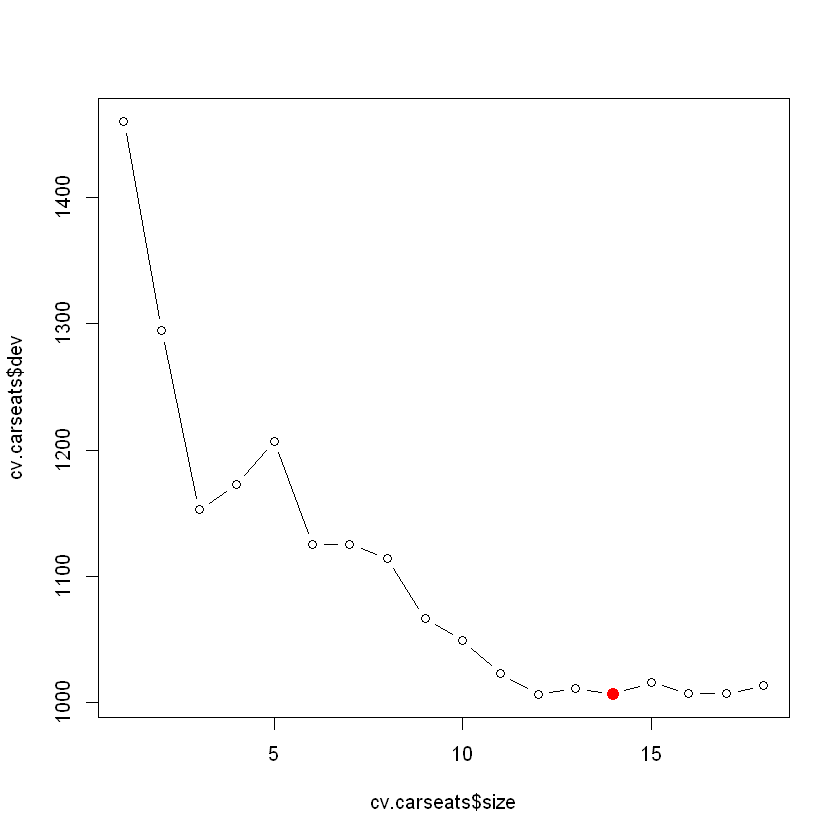

[1] 2.76144

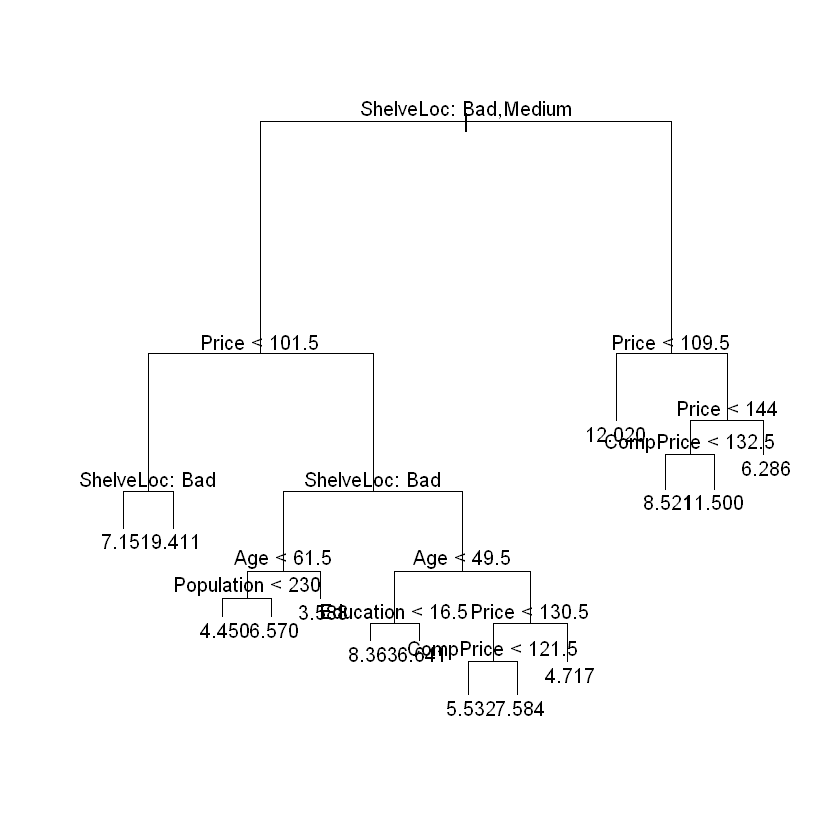

In [9]:
#EXERCISE 8, CHAPTER 8   

#reference: https://github.com/leetschau/ISLNotes/blob/master/ch8applied.Rmd

#A,B) build a regression tree on training set and calculate its MSE:
library(ISLR)
library(tree)
set.seed(123)


train <- sample(1 : nrow(Carseats), nrow(Carseats) / 2)
tree.carseats <- tree(Sales ~ ., data = Carseats, subset = train)
plot(tree.carseats)
text(tree.carseats, pretty = 0)
tree.pred <- predict(tree.carseats, Carseats[-train, ])
mean((Carseats[-train, 'Sales'] - tree.pred) ^ 2)

#MSE of complete regression tree is 4.15.

#C) build a pruning tree on training set and calculate its test MSE:

set.seed(123)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.tree)
tree.min <- which.min(cv.carseats$dev)
best.node.no <- cv.carseats$size[tree.min]
prune.carseats <- prune.tree(tree.carseats, best = best.node.no)
tree.pred <- predict(prune.carseats, Carseats[-train, ])
mean((Carseats[-train, 'Sales'] - tree.pred) ^ 2)


#The test MSE of pruning tree is higher than complete tree.
#pruning the tree doesn't prove the test MSE.

plot(cv.carseats$size, cv.carseats$dev, type = "b")
points(best.node.no, cv.carseats$dev[tree.min], col = "red", cex = 2, pch = 20)
plot(prune.carseats)
text(prune.carseats, pretty = 0)


#D)test MSE with bagging approach:
library(randomForest)
set.seed(123)
bag.carseats <- randomForest(Sales ~ ., data = Carseats, subset = train, mtry = ncol(Carseats) - 1, importance = TRUE)
yhat.bag <- predict(bag.carseats, newdata = Carseats[-train, ])
mean((yhat.bag - Carseats[-train, 'Sales']) ^ 2)

#The test MSE is 2.6

#most 2 important predictors are: *Price* and *ShelveLoc*.



In [20]:
#EXERCISE 9, CHAPTER 8
install.packages("e1071", dep = TRUE) 
library(e1071)

#A)
set.seed(123)
train <- sample(nrow(OJ), 800)
OJ.t <- OJ[train, ]
OJ.te <- OJ[-train, ]

#B)
svm.linear <- svm(Purchase ~ ., data = OJ.t, kernel = "linear", cost = 0.01)
summary(svm.linear)


#C
train.p <- predict(svm.linear, OJ.t)
table(OJ.t$Purchase, train.p)
(78 + 55) / (439 + 228 + 78 + 55)
test.p <- predict(svm.linear, OJ.te)
table(OJ.te$Purchase, test.p)
(31 + 18) / (141 + 80 + 31 + 18)


#error rate is 16.60% and test error rate 18.11%.

#D
set.seed(123)
tuneo <- tune(svm, Purchase ~ ., data = OJ.t, kernel = "linear", ranges = list(cost = 10^seq(-2, 1, by = 0.25)))
summary(tuneo)


#E
svm.linear <- svm(Purchase ~ ., kernel = "linear", data = OJ.t, cost = tuneo$best.parameter$cost)
train.p <- predict(svm.linear, OJ.t)
table(OJ.t$Purchase, train.p)
(71 + 56) / (438 + 235 + 71 + 56)
test.p <- predict(svm.linear, OJ.te)
table(OJ.te$Purchase, test.p)
(32 + 19) / (140 + 79 + 32 + 19)


  There is a binary version available but the source version is later:
      binary source needs_compilation
e1071  1.7-6  1.7-9              TRUE

  Binaries will be installed


Warning message:
"package 'e1071' is in use and will not be installed"


Call:
svm(formula = Purchase ~ ., data = OJ.t, kernel = "linear", cost = 0.01)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.01 

Number of Support Vectors:  442

 ( 220 222 )


Number of Classes:  2 

Levels: 
 CH MM




    train.p
      CH  MM
  CH 426  61
  MM  71 242

[1] 0.16625

    test.p
      CH  MM
  CH 145  21
  MM  27  77

[1] 0.1814815


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
     cost
 3.162278

- best performance: 0.16375 

- Detailed performance results:
          cost   error dispersion
1   0.01000000 0.17375 0.04910660
2   0.01778279 0.17250 0.04816061
3   0.03162278 0.17125 0.04678927
4   0.05623413 0.17250 0.04594683
5   0.10000000 0.17500 0.04823265
6   0.17782794 0.17625 0.04427267
7   0.31622777 0.17125 0.04084609
8   0.56234133 0.17125 0.04168749
9   1.00000000 0.16875 0.03963812
10  1.77827941 0.16875 0.04135299
11  3.16227766 0.16375 0.04185375
12  5.62341325 0.17125 0.03998698
13 10.00000000 0.17000 0.04005205


    train.p
      CH  MM
  CH 427  60
  MM  69 244

[1] 0.15875

    test.p
      CH  MM
  CH 149  17
  MM  25  79

[1] 0.1888889

In [21]:
#EXERCISE 10, CHAPTER 8
#A
sum(is.na(Hitters$Salary))



[1] 59

In [24]:
Hitters <- Hitters[-which(is.na(Hitters$Salary)), ]
sum(is.na(Hitters$Salary))

[1] 0

In [27]:
H <- Hitters$Salary <- log(Hitters$Salary)


In [28]:
#B

train <- 1:200
t_set <- Hitters[train, ]
te_set <- Hitters[-train, ]

In [37]:
#C
set.seed(123)
lambda <- 10 ^ seq(-10, -0.2, length = 100)
t_errors <- rep(NA, length(lambda))
t_errors <- rep(NA, length(lambda))


In [39]:
#D
